


## **Section 1: Introduction and Summary**
This notebook intends to analyze, compare and provide insights on the performance of two well known models (1 econometric and 1 machine learning) - ARIMAX (Autoregressive Integrated Moving Average with Exogenous Regressors) and XGBoost (Extreme Gradient Boosting) across the following parameters:

**1. Out-of-Sample Performance:** How well the model forecasts previously unseen data (test data) - measured using RMSE (Root Mean Squared Error) and MAE (Mean Absolute Error).

**2. Viability of Long-Run Forecasts:** How economically plausible or structurally meaningful the long-run forecasts appear - assessed using qualitative and contextual judgment.

Based on the findings above, this notebook strives to determine **Model Applicability**. I.e., which model demonstrates **better predictive power** and which one provides **better macro-economic plausibility**.

Additionally, the notebook explains the underlying engine - both mathematically and intuitively - of each model - to provide the reader with a clear understanding of what goes on under the hood.

The analysis uses the official All-India Consumer Price Index (CPI – Combined) year-on-year (YoY) inflation series (January-2013 to August-2025) published by the Ministry of Statistics & Programme Implementation (MoSPI), Government of India. MoSPI’s CPI (Base Year 2012 = 100) is the standard measure of retail price inflation and is released monthly through the National Statistical Office (NSO) press-release annexures. Since prior to 2012 India did not report on a **Combined** CPI figure (and base years fluctuated: 2001, 1986-87, 1984-85), we have limited our dataset to 12 years and 6 months. While this limits our historical vantage point, inclusion of statistically significant exogenous factors (over the same period) drastically improves model performance.


**Dataset Description:**

The dataset employed here spans January 2013 through August 2025 and provides the monthly percentage change in the General CPI over the corresponding month of the previous year. One calendar year—2020—has been imputed due to lack of information for some months. This year coincides with the peak of the COVID-19 pandemic, when India experienced:

1. Unprecedented supply-chain disruptions and demand shocks,
2. Nation-wide lockdowns and abrupt changes in consumption patterns, and
3. Gaps in official data collection, with MoSPI itself noting that CPI for April–May 2020 could not be compiled.

Since ARIMAX requires continuous monthly data, inflation figures for 2020 have been imputed using STL (Seasonality Trend Decomposition using LOESS). Although STL assumes stable seasonal structure, which may not fully hold during pandemic-induced disruptions, it offers a transparent and reproducible decomposition-based method suitable for ARIMAX continuity requirements.

Augmenting the endogenous dataset (Inflation Rate in our case) with exogenous factors is a known practice adopted to improve overall model performance and hence, this notebook identifies the following 4 exogenous factors that will be used with both models to ensure an apple-to-apple comparison:

1. *F&B inflation (determined using CFPI)* - Food and beverages make up ~46% of India's goods basket and CFPI and Inflation demonstrate a strong positive correlation (demonstrated in subsequent sections of this notebook). Source: DBIE (Database on Indian Economy)
2. *Brent crude prices* - India imports 85% of its oil and Oil prices and Inflation demonstrate a medium to weak positive correlation (demonstrated in subsequent sections of this notebook). Source: FRED (Federal Reserve Bank of St. Louis).
3. *USD to INR exchange rate (FX)* - India imports commodities, energy, machinery and hence, any movement (appreciation/depreciation) will play a key role in our model. Additionally, FX and Inflation demonstrate a medium to weak negative correlation (while this might go against established economic theory, this relationship is empirically demonstrated in subsequent sections of this notebook). Source: DBIE (Database on Indian Economy).
4. *Repo (repurchase option) rate* - RBI policy rate is a key determinant of demand-side inflation and Repo and Inflation demonstrate a medium to weak positive correlation (demonstrated in subsequent sections of this notebook). Source: MasterstrokeOnline (2013-23), 2024 rates held constant from 2023 (since no reported MPC meeting held) and 2025 rates taken from RBI press release.

**Modelling Approach:**

Subsequent sections of this notebook outline the data-preparation steps, stationarity diagnostics, and the implementation of: 

- One classical time-series model — specifically an ARIMAX specification; and 
- One supervised ML model (XGBoost)

These models are used to generate monthly forecasts of India’s headline inflation (endogenous variable) for the next 60 months (from last model training date). These projections (along with each model's out-of-sample performance) are then evaluated to compare each model and determine their respective applicability. **Important Note:** Since XGBoost is not a time-series model by design, lagged autoregressive terms and exogenous variables were manually engineered to enable forecasting.

**ARIMAX Pipeline:**

The pipeline for implementation of any classical time series econometric model starts with statistical diagnostics on the underlying series to detect trend-stationarity, seasonality, and autocorrelation patterns. These tests are critical in determining the values for model coefficients (p, d, q, P, D, Q, s) which are explained in the subsequent sections. Hence, our implementation employed the following steps:

*1. Stationarity and Seasonality Tests:*

ARIMA-family models require the input series to be stationary. Therefore, statistical tests are performed to determine whether trend differencing (d) or seasonal differencing (D) is required. This is because the mathematics of such models rely on the underlying data to be stationary (both from trend and seasonality perspectives). Hence, tests such as ADF (Augmented Dickey Fuller) and KPSS (Kwiatkowski-Phillips-Schmidt-Shin) are employed to determine the need for trend differencing and Hyndman and CH (Canova-Hansen) are employed to determine the need for seasonality differencing. Additionally, an ACF (Autocorrelation Function) plot is developed to determine persistence (how well the past captures the present) and repeating autocorrelation patterns in the underlying data. This notebook performs all these tests and explains the underlying math as well as an interpretation of each of these tests (in the context of our use case).

*2. Model Implementation and Tuning:*

Based on identified parameters for trend and seasonality differencing, the model is then implemented on the dataset (in conjunction with the exogenous data) and fine-tuned based on its performance on in-sample-statistics such as log-likelihood, AIC (Akaike Information Criterion), BIC (Bayesian Information Criterion) and p-values of the various model coefficients. Additionally, residual diagnostics (including Ljung–Box tests for autocorrelation) were also examined to validate model adequacy and a train-test split of 80-20 was employed. Although multiple iterations of model parameters were employed to identify the model with best in-sample-performance, for simplicity purposes, this notebook does not provide a comparison of these iterations.

**XGBoost Pipeline (CUDA enabled):**

Since XGBoost is a supervised machine learning algorithm with no inherent notion of temporal dependence, lagged features—applied to both the target (endogenous variable) and the exogenous variables—must be manually engineered to capture autoregressive structure. Additionally, to improve model training time, the XGBoost was implemented in a CUDA (Compute Unified Device Architecture)-enabled WSL (Windows Subsystem for Linux) environment. Hence, the implementation employed the following steps:

*1. Feature Engineering:*

For our use case, we employed the development of the following features (on both the target as well as available features):

 - Lags (1, 2 and 3)
 - Moving Averages (3, 6 and 12)
 - Rolling Volatility (3, 6 and 12)
 - Month-on-Month %age Changes
 - First-Order Differencing
 - Month, Quarter and Year splits of the dates

*2. Model Training, Test and Hyperparameter Tuning:*

Subsequent to feature engineering, the data was split into train (90%) and test (10%). While the train and test split goes against established conventions of 80-20, the split of 90-10 was identified since ML models require more data than ARIMA during training and a 10% test set is still statistically meaningful in time-series forecasting. Additionally, hyperparameters were tuned using iterative search over learning rate, max_depth, subsample, column subsampling rate and regularization parameters (L1 and L2). Similar to the approach adopted for ARIMAX above, while multiple iterations of model parameters were employed to identify the best-fit model, for simplicity purposes, this notebook does not provide a comparison of these iterations.

**DISCLAIMER:** This notebook's intention is solely to compare a classical time-series model and a supervised model to determine the strengths and weaknesses of each. This notebook (and its conclusions) **DO NOT intend to conclusively determine long-run inflation forecasts for any form of financial/ economic interpretation**. Accurate long run forecasts require the presence of multiple exogenous variables that have not been considered as part of this research. Hence, long-horizon projections should be interpreted as indicative - rather than definitive. Furthermore, both models assume historical relationships remain stable, which may not hold in the presence of structural breaks such as commodity shocks, major policy shifts, or geopolitical disruptions.

In [115]:
# Importing necessary packages for the model
import os
from dotenv import load_dotenv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime as dt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import STL
import matplotlib.dates as mdates
from pmdarima.arima import CHTest
from pmdarima import auto_arima
from scipy.stats import pearsonr
import warnings
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
warnings.simplefilter("ignore")
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller, kpss
import xgboost as xgb
from dateutil.relativedelta import relativedelta
import time

## **Section 2: Data Preparation and Visualization**
This section shows a visual representation of the inflation data - as sourced from MoSPI, performs imputation of missing data (using seasonality decomposition) and plots the imputed dataset for comparison with the original.

Revised inflation dataset - after setting date as index:
            CPI_Inflation_YoY_Percent
Date                                 
2013-01-01                      10.38
2013-02-01                      10.51
2013-03-01                       9.97
2013-04-01                       9.00
2013-05-01                       8.72


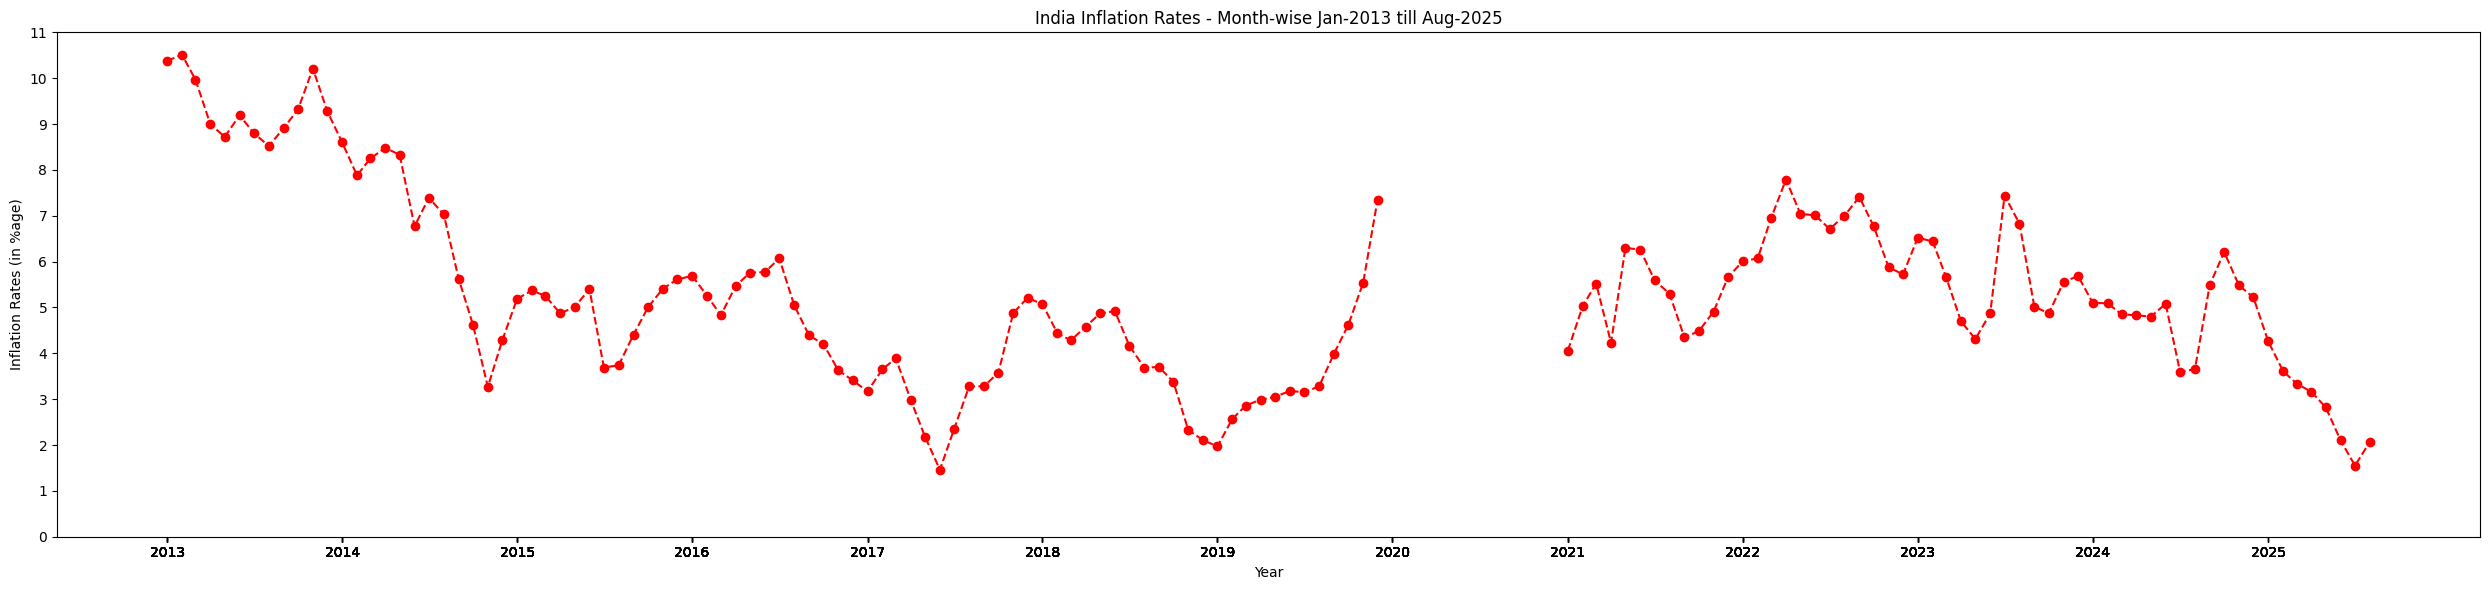

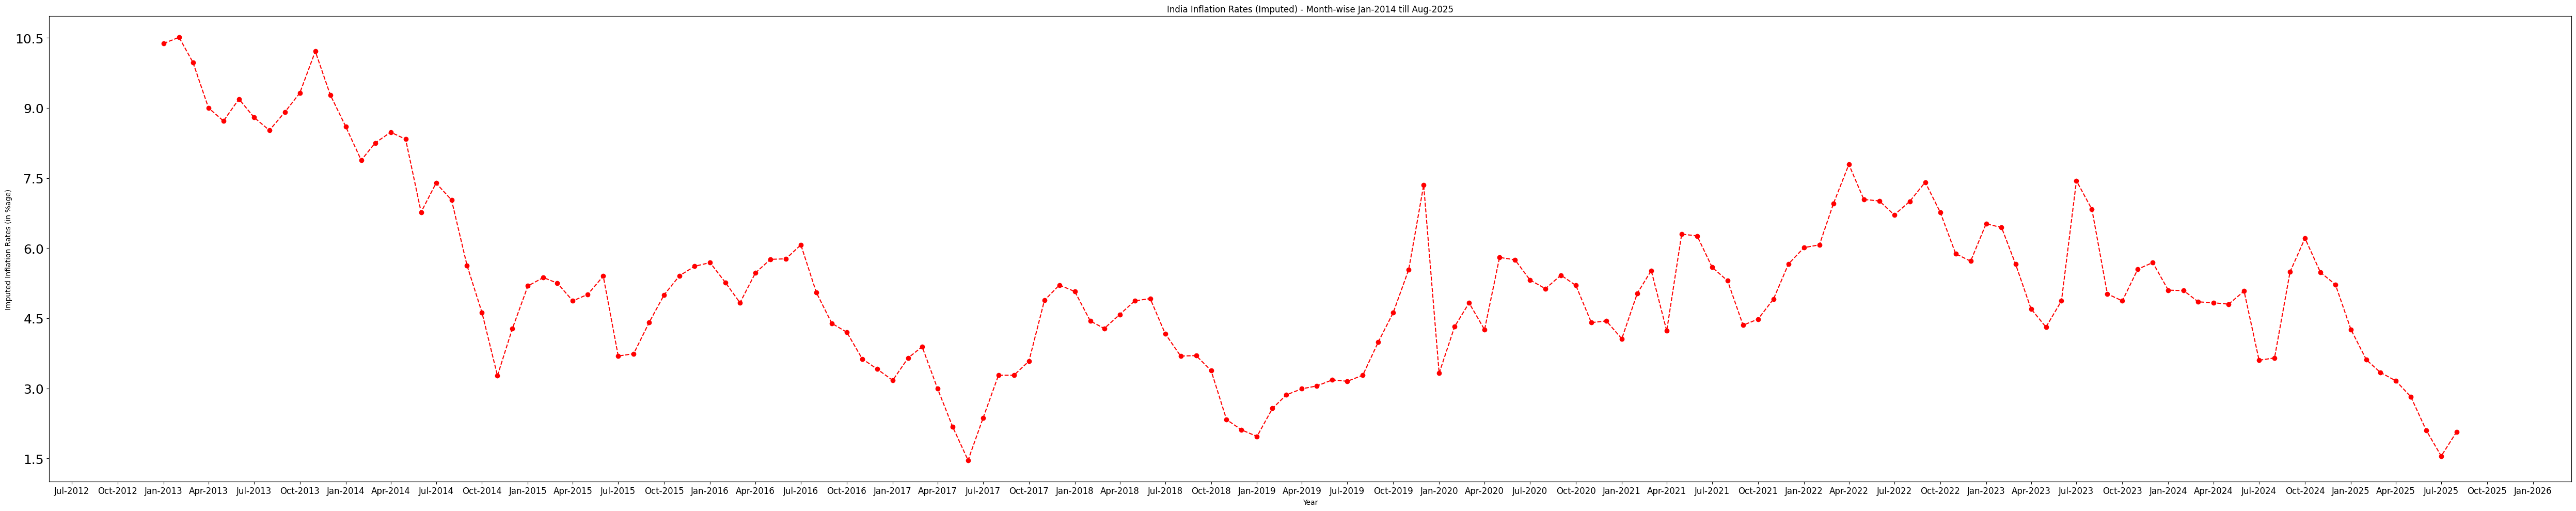

In [116]:
# Record program start time
start_time = time.time()

# Initialize environment and set conditions
load_dotenv()
inflation_dataset = os.getenv('inflation_dataset')
arimax_forecast_imputed_dataset = os.getenv('arimax_forecast_imputed_dataset')
xgboost_forecast_imputed_dataset = os.getenv('xgboost_forecast_imputed_dataset')
feature_dataset = os.getenv('feature_dataset')
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Load original data
df_inflation = pd.read_csv(inflation_dataset)
X_values = [dt.strptime(d, '%m/%d/%Y') for d in df_inflation['Date']]
Y_values = df_inflation['CPI_Inflation_YoY_Percent'].to_list()
Y_ticks = [round(i) for i in range(int(max(Y_values)+2))]
X_ticks = [dt.strftime(d, '%Y') for d in X_values]

# Visualize original data
fig, ax = plt.subplots(figsize=(25, 6), dpi=100)
ax.plot(X_values, Y_values, '--', color='red', marker='o')
ax.set_title('India Inflation Rates - Month-wise Jan-2013 till Aug-2025')
ax.set_xlabel('Year')
ax.set_ylabel('Inflation Rates (in %age)')
ax.set_xticks(X_ticks)
ax.set_yticks(Y_ticks)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
fig.tight_layout()

# Setting date as index, converting to monthly frequency and generating time interpolated data.
df_inflation['Date'] = pd.to_datetime(df_inflation['Date'])
df_inflation_imputed = pd.DataFrame(df_inflation)
df_inflation_imputed.set_index('Date', inplace=True)
df_inflation_imputed = df_inflation_imputed.asfreq('MS')
df_inflation_imputed = df_inflation_imputed.sort_index()
print(f'Revised inflation dataset - after setting date as index:\n{df_inflation_imputed.head(5)}')
date_tmp = df_inflation_imputed['CPI_Inflation_YoY_Percent'].interpolate(method='time') # Interpolating the data to capture structure.

# Imputing missing values using STL.
stl = STL(date_tmp, period=12, robust=True).fit() # Performing seasonal decomposition on interpolated data.
trend, seasonality = stl.trend, stl.seasonal
fill_values = trend + seasonality
df_inflation_imputed['CPI_Inflation_YoY_Percent_Imputed'] = df_inflation_imputed['CPI_Inflation_YoY_Percent'].fillna(fill_values)

# Plotting the imputed data
X_series = df_inflation_imputed.index
Y_series = df_inflation_imputed['CPI_Inflation_YoY_Percent_Imputed']
fig, ax = plt.subplots(figsize=(50, 10), dpi=100)
ax.plot(X_series, Y_series, '--', color='red', marker='o')
ax.set_title('India Inflation Rates (Imputed) - Month-wise Jan-2014 till Aug-2025')
ax.set_xlabel('Year')
ax.set_ylabel('Imputed Inflation Rates (in %age)')
ax.set_xticks(X_series)
ax.set_yticks(Y_series)
ax.xaxis.set_major_locator(mdates.MonthLocator([1, 4, 7, 10]))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
ax.yaxis.set_major_locator(plt.MaxNLocator(8))
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=18)
fig.tight_layout()
plt.show()

# Training and Testing Data Preparation
df_endogenous = df_inflation_imputed[
    df_inflation_imputed.index >= '2014-01-01'
]
train_endogenous_data = df_endogenous[
    df_endogenous.index <= '2024-08-01'
]
test_endogenous_data = df_endogenous[
    df_endogenous.index > '2024-08-01'
]

## **Section 3: Introduction to Time-Series Models, Trend Stationarity Test and Differencing**
Time-series data can be represented through additive or multiplicative decompositions when analyzing trend, seasonality, and residual structure. This decomposition is useful for understanding patterns in the data, but it is not the model used by ARIMA/SARIMAX. Classical time-series models such as ARIMA/SARIMAX instead rely on differencing and autoregressive/moving-average components to capture trend and serial dependence which have been elaborated in the subsequent sections.

Under the additive method, following are the typical equations of a time-series model:

For an additive decomposition (as explained in Section 3 above):
$$
y_t = T_t + S_t + R_t,
$$
where $$T_t = trend, S_t = seasonal component, R_t = remainder (noise).$$

For multiplicative behavior, use a log transform and decompose additively:
$$
\log y_t = T_t + S_t + R_t \quad \iff \quad y_t = e^{T_t}\cdot e^{S_t}\cdot e^{R_t}.
$$

**Additive vs. multiplicative?**
- If amplitude is roughly **constant** - which is typically the case for inflation rates, use **additive**.
- If amplitude **scales with the level** - typically seen in revenue, sales data, decompose **log(y)** additively (equivalently multiplicative on \(y\)).

ARIMA/SARIMAX models require the underlying stochastic component of the series to be **stationary**. This is typically achieved by applying trend differencing (d) and seasonal differencing (D) until the transformed series exhibits stable mean, variance, and autocorrelation structure. A stationary series is one whose statistical properties (mean, variance and autocorrelation structure) do not change over time. Non-stationary data leads to spurious regressions and invalid significance tests. A key point to note: stabilizing the data does **NOT** mean modifying or diluting the raw dataset. Stabilization just improves the data for improved pattern recognition.

This section uses the **Augmented Dickey Fuller (ADF) and Kwiatkowski-Phillips-Schmit-Shin (KPSS)** tests to determine if the trend-series is stationary and if not, differences the data (to make the data stationary). The differenced data is then passed through seasonality tests and the final dataset is then used into the appropriate time-series model.

In practice, ADF and KPSS are used **together** to diagnose trend stationarity:

- ADF non-stationary + KPSS stationary → difference-stationary.
- ADF stationary + KPSS non-stationary → trend-stationary.
- Both stationary or both non-stationary → conclusions confirmed.

This dual testing approach is standard in econometric analysis prior to applying SARIMAX models.

### **3.1. Trend Stationarity Test Using ADF**
This section performs the ADF test on our inflation dataset to determine whether the underlying trend is stationary or not.

#### **About ADF:**
#### ADF: Augmented Dickey–Fuller Test

The **Augmented Dickey–Fuller (ADF)** test is a statistical hypothesis test used to detect the presence of a **unit root** in a time-series. The presence of a unit root indicates **trend non-stationarity**, meaning that the mean and dependence structure of the series change over time.

In simple terms, the ADF test determines whether the observed series is stationary without requiring differencing. A stationary series has constant mean and variance and allows for stable forecasting and statistical inference.

**How ADF works**

The ADF test is based on the following regression:

$$
\Delta y_t = \alpha + \beta\,t + \gamma\,y_{t-1} + \sum_{i=1}^{p}\delta_i\,\Delta y_{t-i} + \varepsilon_t,
$$

where:
- $\Delta y_t$ is the first difference of the series,
- $t$ is an optional deterministic trend,
- $p$ is the number of lagged difference terms,
- $\alpha$ is the intercept/ drift which allows a non-zero mean and captures constant shift,
- $\beta$ is the deterministic trend coefficient which allows the model to test a linear trend,
- $\gamma$ is the coefficient tested for a unit root. I.e., whether the series is stationary. 
    - If $\gamma$ = 0 → the series has a unit root (non-stationary) 
    - If $\gamma$ < 0 → the series is stationary,
- $\varepsilon_t$ is white-noise.
- $\delta_i$ is the coefficient on lagged differenced terms and is used to remove autocorrelation in residuals.

The hypotheses are:

$$
H_0: \gamma = 0 \quad\text{(series has a unit root → non-stationary)},\\
H_1: \gamma < 0 \quad\text{(series is stationary)}.
$$

The test outputs:
1. **ADF statistic** (test statistic),
2. **p-value**,
3. **lag length** used,
4. **critical values** at (1%, 5%, 10%).

**Decision rule**  
Reject $H_0$ if the p-value is below the significance threshold (typically $0.05$) or if the ADF statistic is less than the corresponding critical value.

**Pros vs. Cons**

**Pros**
- Works directly on the raw series without preprocessing.
- Standard method in econometrics for testing unit roots.
- Widely supported in statistical libraries.

**Cons**
- Sensitive to lag selection and structural breaks.
- Low statistical power in short or noisy series.
- Only detects **trend** non-stationarity (not seasonal unit roots).

A typical model selection pipeline uses ADF to determine whether trend differencing is required before applying ARIMAX or SARIMAX models.

In [117]:
# Stationarity Test - Augmented Dickey Fuller
print('Stationarity Test (ADF) on Imputed Inflation Dataset:')
inflation_adf_test_result = adfuller(df_inflation_imputed['CPI_Inflation_YoY_Percent_Imputed'])
inflation_adf_test_stat = inflation_adf_test_result[0]
inflation_adf_test_p_value = inflation_adf_test_result[1]
inflation_adf_test_lags_used = inflation_adf_test_result[2]
inflation_adf_test_obs = inflation_adf_test_result[3]
print(f'Test results:')
print(f'Test statistic: {inflation_adf_test_stat}')
print(f'P-value: {inflation_adf_test_p_value}')
print(f'Number of observations: {inflation_adf_test_obs}')
print(f'Lags used: {inflation_adf_test_lags_used}')

print('\nADF Test Conclusion:')
if inflation_adf_test_p_value > 0.05:
    inflation_adf_test_output = 'Not Stationary'
    print('Fail to Reject H0: Series has a unit root - non-stationary. Differencing needed.')
else:
    inflation_adf_test_output = 'Stationary'
    print('Reject H0: Series is stationary. Differencing not needed.')

Stationarity Test (ADF) on Imputed Inflation Dataset:
Test results:
Test statistic: -2.52013645390992
P-value: 0.11065146297308648
Number of observations: 138
Lags used: 13

ADF Test Conclusion:
Fail to Reject H0: Series has a unit root - non-stationary. Differencing needed.


### **3.2. Trend Stationarity Test Using KPSS**
This section performs the KPSS test on our inflation dataset to determine whether the underlying trend is stationary or not.

#### **About KPSS:**
#### KPSS: Kwiatkowski–Phillips–Schmidt–Shin Test

The **KPSS (Kwiatkowski–Phillips–Schmidt–Shin)** test is a complementary unit-root test to ADF. Unlike ADF, which assumes the series is non-stationary under the null hypothesis, the KPSS test assumes the opposite:

$$
H_0: \text{series is stationary},\\
H_1: \text{series is non-stationary}.
$$

This makes the KPSS test highly useful for validating and resolving ambiguous stationarity behavior detected by ADF.

**How KPSS works**

The KPSS test decomposes the series into a deterministic component (constant or trend), a random walk component, and a stationary residual:

$$
y_t = \mu + \beta,t + r_t + \varepsilon_t,
$$

where:
- $\mu$ is the intercept or level around which the series oscillates,
- $\beta$,t is the trend slope or the deterministic upward/ downward drift,
- $r_t$ is a random-walk or deterministic trend component,
- $\varepsilon_t$ is a stationary error term.

The KPSS statistic is computed from the partial sum of residuals:

$$
\eta = \frac{1}{T^2}\sum_{t=1}^{T}\left(\sum_{i=1}^{t}\hat{\varepsilon}_i\right)^2\Big/\hat{\sigma}^2,
$$

where $\hat{\sigma}^2$ is the long-run variance estimate of $\varepsilon_t$ and $T$ is the sample size.

**Decision rule**  
Reject $H_0$ if the KPSS statistic exceeds its critical value or if the p-value is below the chosen significance threshold.

**Pros vs. Cons**

**Pros**
- Complements ADF by reversing the hypotheses.
- Detects trend-stationary behavior where ADF may be inconclusive.
- Robust for confirming whether differencing is required.

**Cons**
- Sensitive to long-run variance estimation.
- Does not directly differentiate between deterministic trends vs. stochastic trends.

In [118]:
# Stationarity Test - Kwiatkowski-Phillips-Schmidt-Shin
print('Stationarity Test (KPSS) on Imputed Inflation Dataset')
inflation_kpss_test_result = kpss(df_inflation_imputed['CPI_Inflation_YoY_Percent_Imputed'], regression='c') # Used regression='c' since visual inspection of the data shows trend around a constant. In up-ward or down-ward cases, 'ct' is preferred.
inflation_kpss_test_stat = inflation_kpss_test_result[0]
inflation_kpss_test_p_value = inflation_kpss_test_result[1]
inflation_kpss_test_lags_used = inflation_kpss_test_result[2]
print(f'Test results:')
print(f'Test statistic: {inflation_kpss_test_stat}')
print(f'P-value: {inflation_kpss_test_p_value}')
print(f'Lags used: {inflation_kpss_test_lags_used}')

print('\nKPSS Test Conclusion:')
if inflation_kpss_test_p_value > 0.05:
    inflation_kpss_test_output = 'Stationary'
    print('Fail to Reject H0: Series is stationary. Differencing not needed.')
else:
    inflation_kpss_test_output = 'Not Stationary'
    print('Reject H0: Series is non-stationary. Differencing needed.')

Stationarity Test (KPSS) on Imputed Inflation Dataset
Test results:
Test statistic: 0.40882709048495186
P-value: 0.07335039203234833
Lags used: 8

KPSS Test Conclusion:
Fail to Reject H0: Series is stationary. Differencing not needed.


#### **Interpretation of Test Results:**
While cases where ADF fails to reject the NULL hypothesis and KPSS rejects null hypothesis (and vice-versa) are easy to interpret, complications arise when the outcome of one test contradicts the other, i.e. ADF suggests non-stationarity where as KPSS does not. These cases typically arise since ADF and KPSS test different kinds of stationarity:

 - ADF focuses on stochastic persistence (unit root).
 - KPSS focuses on deterministic trend or variance decomposition around a trend.

This is precisely why both ADF and KPSS are needed: individually, they cannot distinguish between difference-stationary and trend-stationary behavior, but together, they provide a clearer diagnosis. The table below outlines the specific actions that need to be taken under different outcomes of the ADF and KPSS tests. Additionally, another important point to note is that when using any models from the ARIMA family, the required action (differencing/ de-trend) should be performed only on the endogenous variable and NOT the exogenous variables. This is because the underlying math behind models of the ARIMA family require ONLY the ENDOGENOUS variable to be stationary (ARIMA differencing operator acts solely on the dependent process).

**Interpretation Table**

| **S.No.** | **ADF Result**        | **KPSS Result**        | **Interpretation**          | **Action**                                                       |
|-----------|-----------------------|------------------------|-----------------------------|------------------------------------------------------------------|
| 1         | Stationary            | Stationary             | Stationary                  | No differencing needed                                           |
| 2         | Non-stationary        | Non-stationary         | Non-stationary              | Apply differencing (d ≥ 1)                                       |
| 3         | Stationary            | Non-stationary         | Difference-stationary       | Apply differencing (d = 1)                                       |
| 4         | Non-stationary        | Stationary             | Trend-stationary            | Detrend or include trend; no differencing                        |


In [119]:
# Final Interpretation
if inflation_adf_test_output == 'Stationary' and inflation_kpss_test_output == 'Stationary':
    inflation_differencing = 0
    print(f'No differencing needed')
elif inflation_adf_test_output == 'Not Stationary' and inflation_kpss_test_output == 'Not Stationary':
    print(f'Differencing needed, Set d >= 1. Final selection of d to be made based on in-sample parameter performance.')
elif inflation_adf_test_output == 'Stationary' and inflation_kpss_test_output == 'Not Stationary':
    inflation_differencing = 1
    print(f'Differencing needed.')
elif inflation_adf_test_output == 'Not Stationary' and inflation_kpss_test_output == 'Stationary':
    inflation_differencing = 0
    inflation_trend = 't'
    print(f'Differencing not needed. De-trend data.')

Differencing not needed. De-trend data.


## **Section 4: Seasonality Tests**
This section uses decomposition and autocorrelation diagnostics to determine if the series has a recurring seasonal pattern and whether seasonal differencing is required before modeling.

Typical workflow for seasonality tests to gauge presence/ strength of seasonality is as follows:
1. **Conduct STL (Seasonal Trend Decomposition with LOESS), and determine Hyndman score**, for initial view of seasonality strength on the dataset. While this statistic gives an explanation on how much of the variance is explained by the seasonal component, it does not prescribe model differencing.
2. **Perform ACF (Autocorrelation Function) analysis** with a sensible maximum lag (e.g. 48 for monthly data). By performing a visual inspection of the output, we can identify significant spikes at multiples of the seasonal period (e.g., 12, 24, etc.). ACF at lag ($k$) is the Pearson Correlation between $X_t$ and $X_{t-k}$ **across all $t$**. Regular spikes at multiples of seasonal period ($s$) indicate seasonal dependence.
3. **Perform CH (Canova-Hansen) test** to conclusively determine the need and value of seasonal differencing.

### **4.1. Preliminary Seasonality Tests Using STL and ACF**
This section performs seasonal decomposition and seasonality strength tests on the dataset. STL (with the additive model) and the subsequent Hyndman score (along with ACF) have been used to establish the presence of seasonality in the dataset and measure its strength.

#### **About STL:**
#### STL: Seasonal–Trend decomposition using Loess
**STL** stands for **Seasonal–Trend decomposition using Loess** (a.k.a. LOWESS: *LOcally WEighted Scatterplot Smoothing*). **LOESS** is a non-parametric smoothing technique that fits many small local regressions around each data point to generate a smooth curve without assuming a global formula and hence, in the context of this analysis, is a better alternative to exponential smoothing or weighted moving average, due to its ability to offer more flexible trend extraction.

**How STL works**

In simple terms, STL splits the raw dataset into 3 components:
1. **Trend** - this component outlines ONLY the underlying trend demonstrated by the raw data (sans the impact of seasonality and residuals).
2. **Seasonal** - this component outlines ONLY the seasonality that is baked into the raw data (sans the trend and residuals).
3. **Residuals** - this component outlines what is left in the raw data - after extracting the trend and seasonality from the same.

Below is a more detailed overview of STL:
1. **Seasonal extraction (cycle–subseries smoothing)**  
   For lag ($k$) (e.g., 12, 24, etc.), split the series into $k$ subseries by season (all Januaries, all Februaries, …) and smooth each subseries with LOESS to get a preliminary $\tilde{S}_t$.
2. **Low-pass filtering of seasonal**  
   Smooth $\tilde{S}_t$ again (moving averages + LOESS) so seasonality changes **slowly** over time.
3. **Trend extraction**  
   Detrend input via $y_t - S_t$, then smooth with LOESS to obtain $T_t$.
4. **Robust reweighting (optional but standard)**  
   Compute residuals $r_t = y_t - T_t - S_t$. Form robustness weights using a bisquare function on scaled residuals (MAD scale):
   $$
   u_t = \frac{r_t}{6\,\mathrm{MAD}(r)},\qquad
   b_t =
   \begin{cases}
   (1-u_t^2)^2,& |u_t|<1\\
   0,& \text{otherwise}
   \end{cases}
   $$
   Re-run seasonal & trend smoothing with weights multiplied by $b_t$ to **down-weight outliers**.
5. **Iterate**  
   STL alternates seasonal ↔ trend updates (inner loop) and robustness updates (outer loop) until changes are small.

**Pros vs. Cons**

**Pros**
- Works for **any seasonal period \(m\)** (not just 12/4).
- Allows **seasonality to evolve** over time.
- **Robust** to outliers (with `robust=True`).
- Transparent smoothness controls: `s.window` (seasonal), `t.window` (trend).

**Cons**
- Requires a **regular, gap-free** series (hence the raw data set has been split into pre and post-COVID data and separate STL tests have been performed on each).
- Window choices affect results (not a single “correct” setting).
- Descriptive method—no built-in forecasting (forecast components or the remainder with a model).

**Quantifying seasonal strength (Hyndman score)**
A handy indicator (0 = none, →1 = strong):
$$
\text{Strength} = \max\left(0,\; 1 - \frac{\mathrm{Var}(R)}{\mathrm{Var}(R+S)}\right).
$$
Higher values mean stronger seasonality.

#### **Seasonal Decomposition:**

Seasonality decomposition and Hyndman Seasonality Strength Score


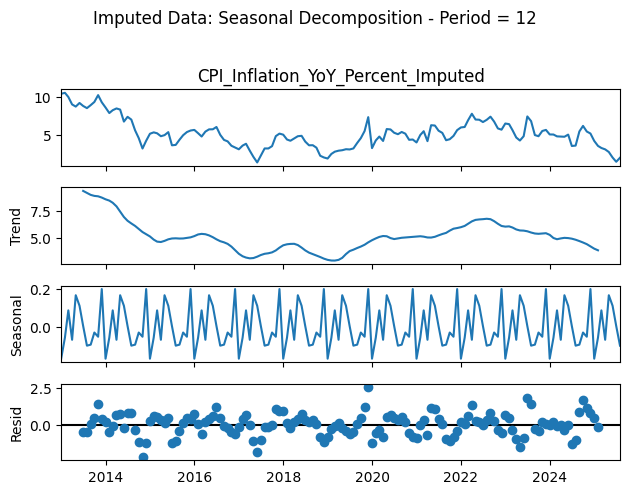

Hyndman Strength Score of Imputed Data: 0.0000
Low seasonality strength in data.


In [120]:
# Seasonal Decomposition
print('Seasonality decomposition and Hyndman Seasonality Strength Score')
seasonal_decompose_imputed = seasonal_decompose(
    df_inflation_imputed['CPI_Inflation_YoY_Percent_Imputed'],
    model='additive',
    period=12
)
fig_imputed = seasonal_decompose_imputed.plot()
fig_imputed.suptitle('Imputed Data: Seasonal Decomposition - Period = 12',
                     fontsize=12,
                     y=1.02)
fig_imputed.tight_layout()
plt.show()

# Hyndman Strength Calculation
stl_imputed = STL(
    df_inflation_imputed['CPI_Inflation_YoY_Percent_Imputed'],
    period=12,
    robust=True
).fit()
trend_imp, seasonality_imp, residual_imp = stl_imputed.trend, stl_imputed.seasonal, stl_imputed.resid
strength_imp = max(
    0, 
    (1 - (residual_imp.var()/(
        residual_imp.var()+seasonality_imp.var()+2*(residual_imp.cov(seasonality_imp))
        )))
    )
print(f'Hyndman Strength Score of Imputed Data: {strength_imp:.4f}')
if strength_imp >= 0 and strength_imp <= 0.3:
    print(f'Low seasonality strength in data.')
else:
    print(f'High seasonality strength in data.')

#### **Interpretation of STL analysis:**
As evidenced from the STL decomposition, the dataset demonstrates low seasonality, as indicated by the Hyndman Seasonality Strength Score. This means that seasonal differencing is not warranted. Additional ACF analysis and the subsequent CH test (presented in later sections) will provide confirmatory evidence regarding the presence or absence of seasonal unit roots.

#### **About ACF**
#### ACF: Autocorrelation Function
**ACF** measures linear correlation between a time series and **lagged** versions of itself. I.e., for lag $k$, it asks “how similar is $y_t$ to $y_{t-k}$?”

**How ACF works (high-level)**

In simple terms, ACF plots the correlation between the value of a series ($y_i$) at time $t$ and its value at time $t-k$ or $k$ periods earlier. The result (when applied across all data points in a series $Y$), gives us a graph that plots the correlations (vertical bars) between value of the series at time $t$ and value of the same series at time $t-k$ and the ±1.96/√n bands (shaded area). An ACF that shows significant spikes specifically at multiples of the seasonal period (e.g., 12, 24, 36 for monthly data), i.e., beyond the ±1.96/√n bands - then we can assume (with 95% confidence, if alpha = 5%) that seasonality is present in the raw data. However, generic oscillatory patterns do not guarantee seasonality and may arise from autoregressive dynamics. Hence, a CH test (explained in the subsequent sections) is warranted to determine seasonal root.

Below is a more detailed overview of ACF:

1. **Determine autocovariance**:
    For a weakly stationary series (i.e., a series of data whose mean $\mu$ and variance $\sigma^2$ do not change over time) $Y$, with mean $\mu$ and variance $\sigma^2$, determine the **autocovariance** at lag $k$, given as:

    $$
    \gamma(k) \;=\; \operatorname{Cov}(y_t,\; y_{t-k})
    \;=\; \mathbb{E}\!\big[(y_t-\mu)(y_{t-k}-\mu)\big].
    $$

    which measures the covariance between today’s value $y_t$ and the value $k$ time steps earlier ($y_{t-k}$).

2. **Determine autocorrelation**: 
    The **autocorrelation** at lag $k$ for the series $Y$ is then determined using:

    $$
    \rho(k) \;=\; \frac{\gamma(k)}{\gamma(0)} \;=\; \frac{\gamma(k)}{\sigma^2}.
    $$

    which normalizes the covariance (by the variance) so the result is a pure correlation coefficient (i.e., values lie between -1 and 1).

**ACF application in real data**:
Since, in the case of real data, we do not know the true mean or true expected values, we typically use the **sample ACF** method; given using the equation:

$$
\hat{\rho}(k)
\;=\;
\frac{\sum_{t=k+1}^{n}(y_t-\bar y)(y_{t-k}-\bar y)}
     {\sum_{t=1}^{n}(y_t-\bar y)^2},
$$

where $\bar y$ is the sample mean (which replaces the true mean) and $\sum$ is summation of the data (which replaces the expected values $\mathbb{E}$) 

**Interpretation of ACF:**
- **Seasonality:** Significant spikes at **seasonal lags** (e.g., $12, 24, 36,\dots$ for monthly data).
- **Trend / non-stationarity:** ACF that **decays slowly** (stays high for many lags) → likely non-stationary → difference first.
- If the ACF shows spikes at $12, 24, …$ → seasonal dynamics present (consider **SARIMAX**).
- If ACF decays slowly → **difference (and possibly seasonal difference)**.

**Significance & confidence bands**
Under the null hypothesis of white noise (i.e., zero mean, constant variance, and no predictable pattern), approximate 95 % confidence bands are:  (Bartlett’s formula provides a more exact variance):
$$
\pm \frac{1.96}{\sqrt{n}},
$$
for each individual lag. Bartlett’s formula provides an exact variance for these bands.
For statistical significance, we can use **Ljung–Box** to jointly test “no autocorrelation up to lag $k$” where if p-value < chosen significance level (e.g. 0.05), we reject $H_o$ $\rightarrow$ to conclude that there is significant autocorrelation somewhere among the first $k$ lags.

#### **ACF Analysis:**

ACF plot of imputed data for visual assessment of seasonality


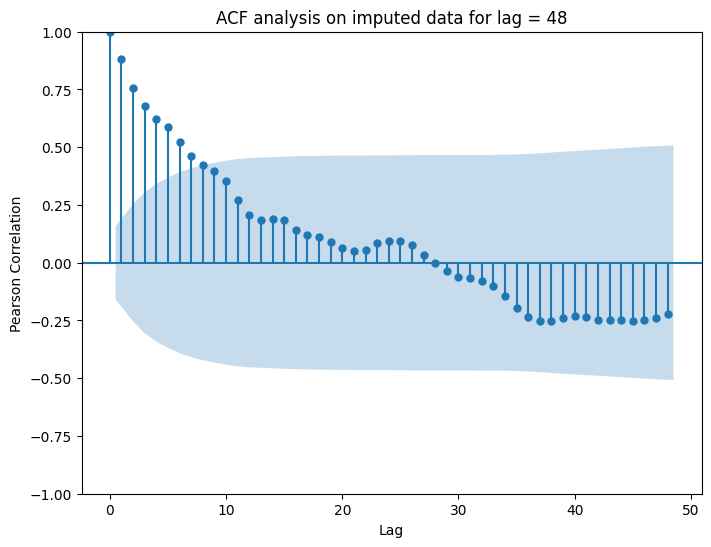

In [121]:
# ACF Plot of Imputed Data
print('ACF plot of imputed data for visual assessment of seasonality')
fig_imputed_acf, ax_imputed_acf = plt.subplots(figsize=(8 , 6), dpi=100)
plot_imputed_acf = plot_acf(
    df_inflation_imputed['CPI_Inflation_YoY_Percent_Imputed'],
    lags=48,
    ax=ax_imputed_acf
)
ax_imputed_acf.set_title('ACF analysis on imputed data for lag = 48')
ax_imputed_acf.set_xlabel('Lag')
ax_imputed_acf.set_ylabel('Pearson Correlation')
plt.show()

#### **Interpretaion of ACF analysis:**

Consistent with the STL and Hyndman strength results, the ACF does not show pronounced spikes at seasonal lags (12, 24, 36, 48), indicating no strong seasonal pattern in the data. At the same time, the ACF exhibits a slow decay, which suggests strong persistence and is consistent with either a highly persistent AR process or possible non-stationarity in levels. The final Canova–Hansen test will specifically assess whetherwhether seasonal patterns are stable over time and hence, whether seasonal differencing is warranted. Non-seasonal differencing (d) is motivated primarily by the persistence and slow decay in the ACF, whereas seasonal differencing (D) is guided by the CH test.

### **4.2. Final Seasonality Test - CH test**
This section uses the Canova-Hansen (CH) test to conclusively determine the presence of a seasonal unit root in the dataset. Based on the outcomes of this test, we will conclusively determine whether seasonal differencing is warranted.

#### **About CH:**
#### CH: Canova-Hansen Test
The **Canova–Hansen** test assesses whether seasonal patterns are stable over time. A large test statistic suggests unstable seasonality, for which seasonal differencing (D=1) is appropriate.

**Null ($H_0$) and Alternate ($H_1$) Hypothesis in CH Test**
- Null ($H_0$) Hypothesis: the series has a seasonal unit root $\rightarrow$ seasonal differencing needed - select SARIMAX.
- Alternate ($H_1$) Hypothesis: the series does not contain a seasonal unit root $\rightarrow$ seasonal differencing not needed - proceed with ARIMAX.

**Definition of Seasonal Root**

Presence of a seasonal unit root in a series means that seasonality in the dataset does not follow a repeating (osciallting) pattern. E.g., A monthly series whose January values have a mean that drifts over time rather than repeating around a constant seasonal mean.

**Practical Interpretation of Seasonal Root**

Presence of a seasonal unit root means that the data must be differenced at the seasonal lag to remove the stochastic seasonal component. After removing the seasonal component, the remaining series should be stationary and suitable for forecast modelling.

**How CH Test works**

In simple terms, a CH test performs a discrete Fourier Transform on seasonal regressons (sine, cosine pairs built on only the stochastic part of the dataset) called **Periodogram Ordinates** and takes a variance-weighted sum of these ordinates to determine the **Test Statistic**. The test statistic is then compared to critical values ($p_value$ < 0.05 or $p_value$ > 0.05) to determine the final decision on whether to accept or reject the **null hypothesis**.

#### **CH Test:**

In [122]:
# Cannova-Hansen Test for Seasonal Differencing
print('Cannova-Hansen test on imputed data to determine seasonal differencing:')
imputed_inflation_data = df_inflation_imputed['CPI_Inflation_YoY_Percent_Imputed'].astype('float64').to_numpy()
ch_imputed = CHTest(m=12)
D_imputed = ch_imputed.estimate_seasonal_differencing_term(imputed_inflation_data)
print('Result of Cannova-Hansen Test on Imputed Data:')
if D_imputed > 0.4:
    print(f'Estimated differencing value: {D_imputed:.4f}.')
else:
    print(f'Estimated differencing value: {D_imputed:.4f}.')

Cannova-Hansen test on imputed data to determine seasonal differencing:
Result of Cannova-Hansen Test on Imputed Data:
Estimated differencing value: 0.0000.


#### **Interpretaion of CH Test:**

As stated before, the Canova–Hansen test evaluates whether the seasonal pattern in a time series is stable (deterministic) or unstable (stochastic). Since the implementation in pmdarima returns a test statistic but not p-values, we adopt the standard heuristic threshold of 0.4: statistics above 0.4 indicate unstable seasonality, for which seasonal differencing (D = 1) is recommended; values below 0.4 indicate stable seasonality, implying that seasonal differencing is not required (D = 0). For our dataset, the CH statistic is 0.0000, which is far below the threshold. This indicates that the seasonal pattern—if present—is highly stable and does not warrant seasonal differencing. Therefore, the seasonal differencing order is set to D = 0.

## **Section 5: Identification of Exogenous Factors**
This section focuses on identifying external macroeconomic variables that exhibit empirical comovement with CPI inflation. Augmenting time series and machine learning models with exogenous factors have been known to improve overall model performance and hence, this notebook identifies the following 4 factors:

1. *F&B inflation (determined using CFPI)* - Food and beverages make up ~46% of India's goods basket and CFPI and Inflation demonstrate a strong positive correlation (demonstrated in subsequent sections of this notebook). Source: DBIE (Database on Indian Economy)
2. *Brent crude prices* - India imports 85% of its oil and Oil prices and Inflation demonstrate a medium to weak positive correlation (demonstrated in subsequent sections of this notebook). Source: FRED (Federal Reserve Bank of St. Louis).
3. *USD to INR exchange rate (FX)* - India imports commodities, energy, machinery and hence, any movement (appreciation/depreciation) will play a key role in our model. Additionally, FX and Inflation demonstrate a medium to weak negative correlation (while this might go against established economic theory, this relationship is empirically demonstrated in subsequent sections of this notebook). Source: DBIE (Database on Indian Economy).
4. *Repo (repurchase option) rate* - RBI policy rate is a key determinant of demand-side inflation and Repo and Inflation demonstrate a medium to weak positive correlation (demonstrated in subsequent sections of this notebook). Source: MasterstrokeOnline (2013-23), 2024 rates held constant from 2023 (since no reported MPC meeting held) and 2025 rates taken from RBI press release.

To evaluate empirical relationships between each factor and CPI Inflation Rate, we will perform the following tests between each of the 4 variables above, and inflation.

1. **Pearson Correlation:** to determine direction and strength of comovement.
2. **ADF and KPSS:** to determine need for trend-differencing (of each exogenous variable) before inclusion in the model - so that the regression is well-specified.

Together, these diagnostics help verify that each variable is statistically appropriate for inclusion as an exogenous regressor. Additionally, these variables are widely recognized in macroeconomic literature as key drivers or correlates of domestic inflation, and their inclusion helps capture influences that the endogenous series alone cannot explain.

### **5.1. CFPI and Inflation**

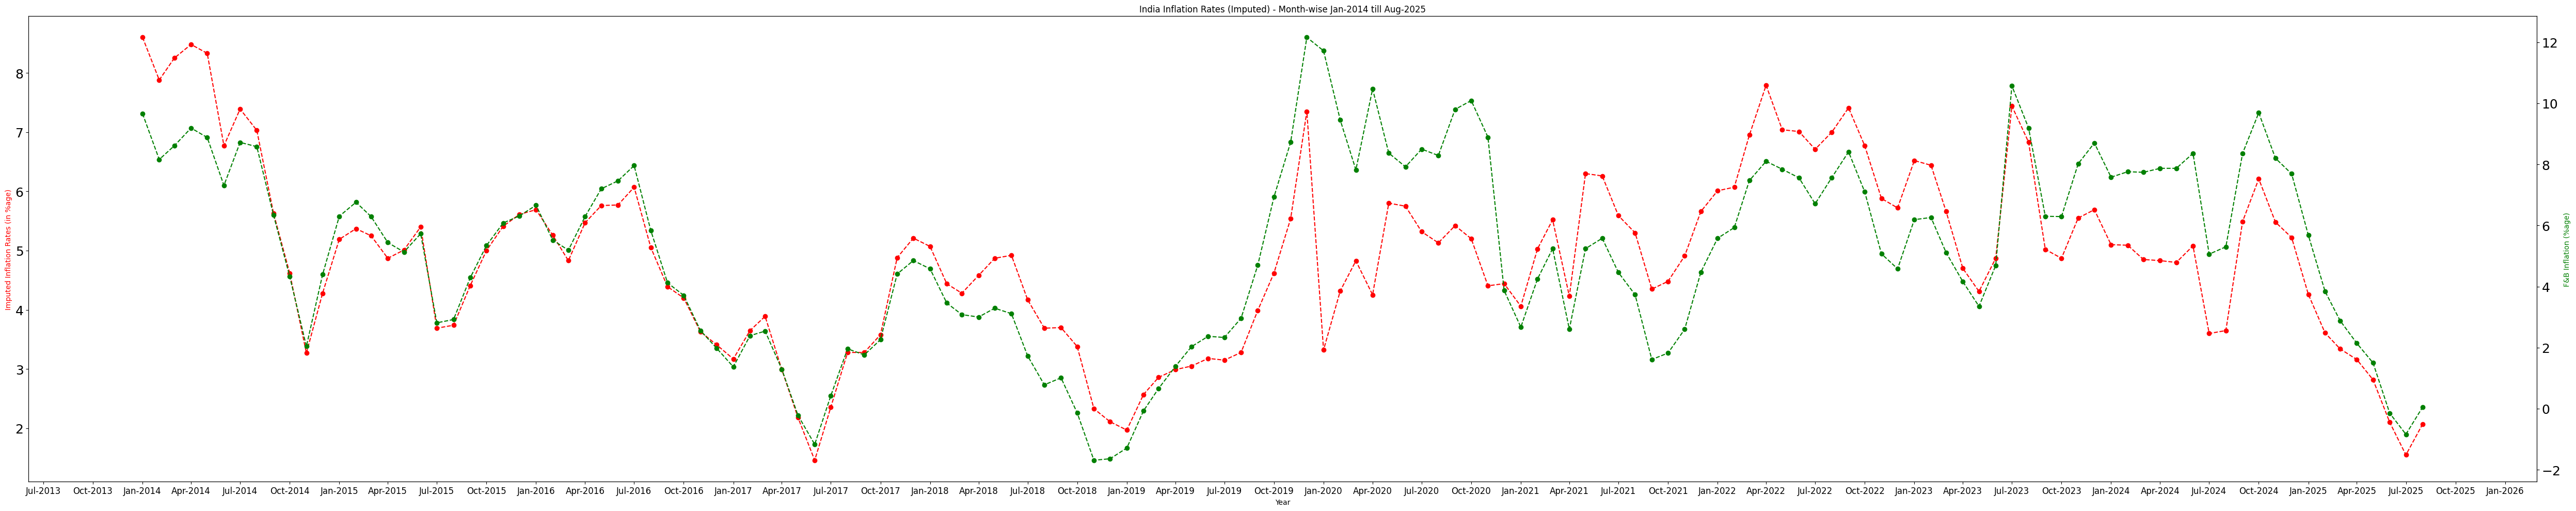

Pearson Correlation Between CFPI and Inflation
Correlation: 0.7851 and P-value: 0.0000

Pearson Correlation Result (CFPI and Inflation):
Strong positive linear correlation between f&b inflation and inflation.
Stationarity Test (ADF) on CFPI Dataset - Trend Component:
Test results:
Test statistic: -2.0242447905920025
P-value: 0.27604480878172044
Number of observations: 125
Lags used: 14

ADF Test Conclusion:
Fail to Reject H0: Series has a unit root - non-stationary.
Stationarity Test (KPSS) on CFPI Dataset - Trend Component:
Test results:
Test statistic: 0.1787968280009502
P-value: 0.1
Lags used: 6

KPSS Test Conclusion:
Fail to Reject H0: Series is stationary.


In [123]:
# Load data
monthly_avg_cfpi_2014_2025 = os.getenv('monthly_avg_cfpi_2014_2025')
df_cfpi = pd.read_csv(monthly_avg_cfpi_2014_2025)
df_cfpi['Period'] = pd.to_datetime(df_cfpi['Period'])
df_cfpi.set_index('Period', inplace=True)

# Plotting Brent Crude and Inflation Data
X_series = [df_inflation_imputed[
    df_inflation_imputed.index > '2013-12-01'].index
]
X_series = X_series[0]
Y_series_inflation = df_inflation_imputed[
    df_inflation_imputed.index > '2013-12-01'
]
Y_series_inflation = Y_series_inflation['CPI_Inflation_YoY_Percent_Imputed']
Y_series_cfpi = df_cfpi['CFPI_Values']
fig, ax_inf = plt.subplots(figsize=(50, 10), dpi=100)
ax_inf.plot(X_series, Y_series_inflation, '--', color='red', marker='o', label='CPI_Inflation_YoY_Percent_Imputed')
ax_inf.set_title('India Inflation Rates (Imputed) - Month-wise Jan-2014 till Aug-2025')
ax_inf.set_xlabel('Year')
ax_inf.set_ylabel('Imputed Inflation Rates (in %age)', color='red')
ax_inf.set_xticks(X_series)
ax_inf.set_yticks(Y_series_inflation)
ax_inf.xaxis.set_major_locator(mdates.MonthLocator([1, 4, 7, 10]))
ax_inf.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
ax_inf.yaxis.set_major_locator(plt.MaxNLocator(8))
ax_inf.tick_params(axis='x', labelsize=12)
ax_inf.tick_params(axis='y', labelsize=18)
ax_cfpi = ax_inf.twinx()
ax_cfpi.plot(X_series, Y_series_cfpi, '--', color='green', marker='o', label='F&B Inflation (%age)')
ax_cfpi.set_ylabel('F&B Inflation (%age)', color='green')
ax_cfpi.tick_params(axis='y', labelsize=18)
fig.tight_layout()
plt.show()

# Pearson Correlation
print('=========================================================================')
print('Pearson Correlation Between CFPI and Inflation')
cfpi_inf_correl, cfpi_inf_p_value = pearsonr(Y_series_inflation, Y_series_cfpi)
print(f'Correlation: {cfpi_inf_correl:.4f} and P-value: {cfpi_inf_p_value:.4f}')
print('\nPearson Correlation Result (CFPI and Inflation):')
if cfpi_inf_p_value < 0.05:
    if cfpi_inf_correl >= 0.70:
        print(f'Strong positive linear correlation between f&b inflation and inflation.')
    elif cfpi_inf_correl >= 0.10 and cfpi_inf_correl < 0.70:
        print(f'Medium to weak positive linear correlation between f&b inflation and inflation.')
    elif cfpi_inf_correl > -0.10 and cfpi_inf_correl < 0.10:
        print(f'No/ negligible linear correlation between f&b inflation and inflation.')
    elif cfpi_inf_correl > -0.70 and cfpi_inf_correl <= -0.10:
        print(f'Medium to weak negative linear correlation between f&b inflation and inflation.')
    elif cfpi_inf_correl <= -0.70:
        print(f'Strong negative linear correlation between f&b inflation and inflation.')

# Stationarity Test - Augmented Dickey Fuller
print('=========================================================================')
print('Stationarity Test (ADF) on CFPI Dataset - Trend Component:')
cfpi_adf_test_result = adfuller(df_cfpi['CFPI_Values'])
cfpi_adf_test_stat = cfpi_adf_test_result[0]
cfpi_adf_test_p_value = cfpi_adf_test_result[1]
cfpi_adf_test_lags_used = cfpi_adf_test_result[2]
cfpi_adf_test_obs = cfpi_adf_test_result[3]
print(f'Test results:')
print(f'Test statistic: {cfpi_adf_test_stat}')
print(f'P-value: {cfpi_adf_test_p_value}')
print(f'Number of observations: {cfpi_adf_test_obs}')
print(f'Lags used: {cfpi_adf_test_lags_used}')

print('\nADF Test Conclusion:')
if cfpi_adf_test_p_value > 0.05:
    cfpi_adf_test_output = 'Not Stationary'
    print('Fail to Reject H0: Series has a unit root - non-stationary.')
else:
    cfpi_adf_test_output = 'Stationary'
    print('Reject H0: Series is stationary.')

# Stationarity Test - KPSS
print('=========================================================================')
print('Stationarity Test (KPSS) on CFPI Dataset - Trend Component:')
cfpi_kpss_test_result = kpss(df_cfpi['CFPI_Values'])
cfpi_kpss_test_stat = cfpi_kpss_test_result[0]
cfpi_kpss_test_p_value = cfpi_kpss_test_result[1]
cfpi_kpss_test_lags_used = cfpi_kpss_test_result[2]
cfpi_kpss_test_obs = cfpi_kpss_test_result[3]
print(f'Test results:')
print(f'Test statistic: {cfpi_kpss_test_stat}')
print(f'P-value: {cfpi_kpss_test_p_value}')
print(f'Lags used: {cfpi_kpss_test_lags_used}')

print('\nKPSS Test Conclusion:')
if cfpi_kpss_test_p_value > 0.05:
    cfpi_kpss_test_output = 'Stationary'
    print('Fail to Reject H0: Series is stationary.')
else:
    cfpi_kpss_test_output = 'Not Stationary'
    print('Reject H0: Series is non-stationary.')

### **5.2. Brent Crude and Inflation**

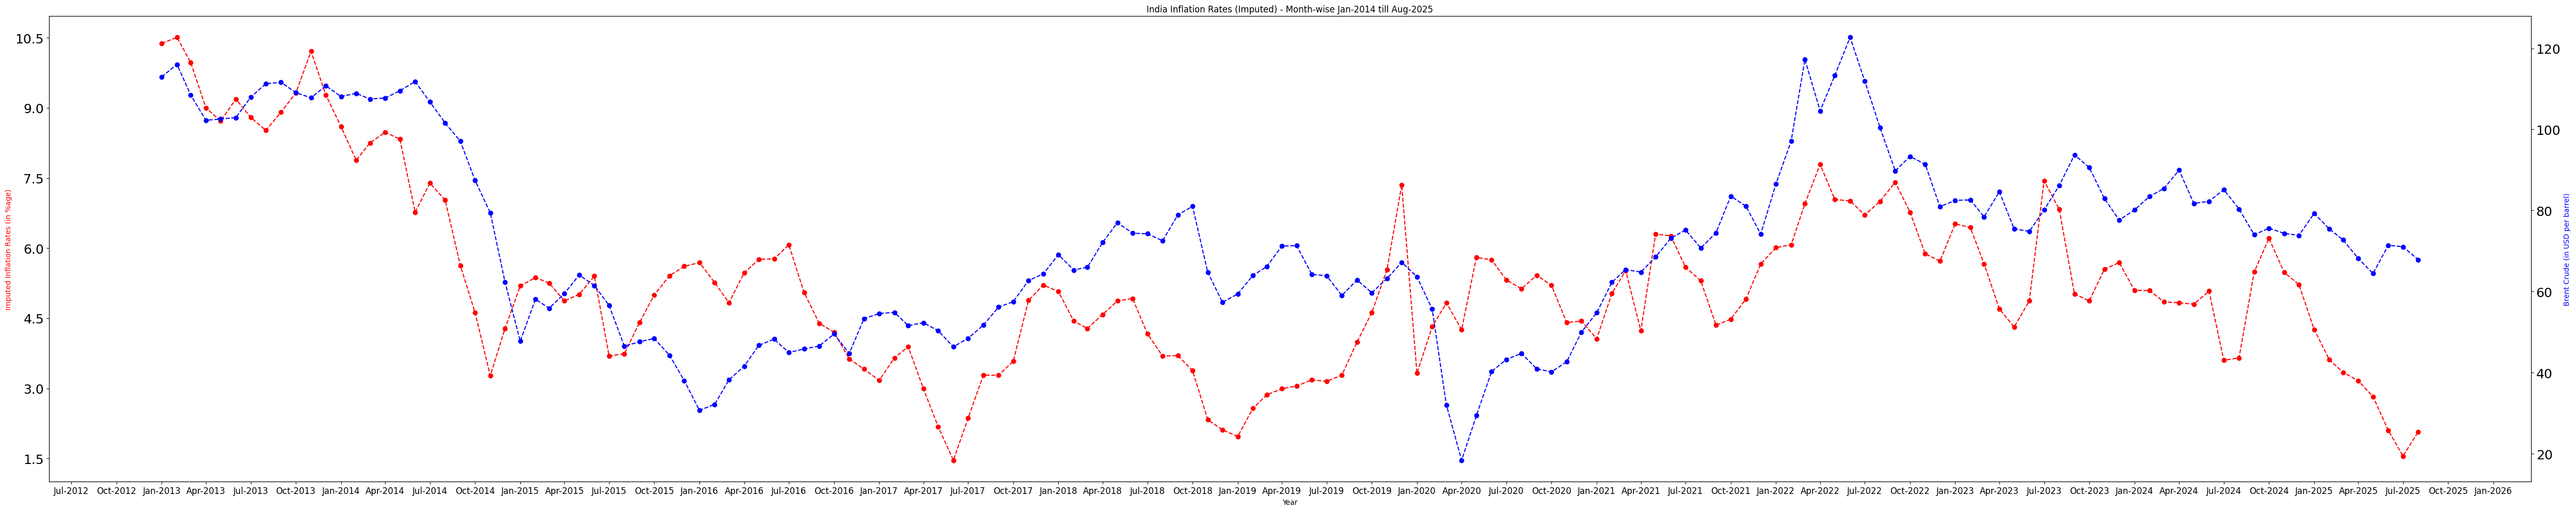

Pearson Correlation Between Brent Crude and Inflation
Correlation: 0.6314 and P-value: 0.0000

Pearson Correlation Result (Brent Crude and Inflation):
Medium to weak positive linear correlation between brent crude and inflation.
Stationarity Test (ADF) on Brent Crude Dataset - Trend Component:
Test results:
Test statistic: -2.6837744514126354
P-value: 0.07688832796667554
Number of observations: 150
Lags used: 1

ADF Test Conclusion:
Fail to Reject H0: Series has a unit root - non-stationary.
Stationarity Test (KPSS) on Brent Crude Dataset - Trend Component:
Test results:
Test statistic: 0.2276907449013167
P-value: 0.1
Lags used: 8

KPSS Test Conclusion:
Fail to Reject H0: Series is stationary.


In [124]:
# Load data
monthly_avg_brent_crude_2013_2025 = os.getenv('monthly_avg_brent_crude_2013_2025')
df_brent_crude = pd.read_csv(monthly_avg_brent_crude_2013_2025)
df_brent_crude['Period'] = pd.to_datetime(df_brent_crude['Period'])
df_brent_crude.set_index('Period', inplace=True)

# Plotting Brent Crude and Inflation Data
X_series = df_inflation_imputed.index
Y_series_inflation = df_inflation_imputed['CPI_Inflation_YoY_Percent_Imputed']
Y_series_brent = df_brent_crude['USD_PER_BARREL']
fig, ax_inf = plt.subplots(figsize=(50, 10), dpi=100)
ax_inf.plot(X_series, Y_series_inflation, '--', color='red', marker='o', label='CPI_Inflation_YoY_Percent_Imputed')
ax_inf.set_title('India Inflation Rates (Imputed) - Month-wise Jan-2014 till Aug-2025')
ax_inf.set_xlabel('Year')
ax_inf.set_ylabel('Imputed Inflation Rates (in %age)', color='red')
ax_inf.set_xticks(X_series)
ax_inf.set_yticks(Y_series_inflation)
ax_inf.xaxis.set_major_locator(mdates.MonthLocator([1, 4, 7, 10]))
ax_inf.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
ax_inf.yaxis.set_major_locator(plt.MaxNLocator(8))
ax_inf.tick_params(axis='x', labelsize=12)
ax_inf.tick_params(axis='y', labelsize=18)
ax_brent = ax_inf.twinx()
ax_brent.plot(X_series, Y_series_brent, '--', color='blue', marker='o', label='Brent_Crude')
ax_brent.set_ylabel('Brent Crude (in USD per barrel)', color='blue')
ax_brent.tick_params(axis='y', labelsize=18)
fig.tight_layout()
plt.show()

# Pearson Correlation
print('=========================================================================')
print('Pearson Correlation Between Brent Crude and Inflation')
brent_inf_correl, brent_inf_p_value = pearsonr(df_inflation_imputed['CPI_Inflation_YoY_Percent_Imputed'], df_brent_crude['USD_PER_BARREL'])
print(f'Correlation: {brent_inf_correl:.4f} and P-value: {brent_inf_p_value:.4f}')
print('\nPearson Correlation Result (Brent Crude and Inflation):')
if brent_inf_p_value < 0.05:
    if brent_inf_correl >= 0.70:
        print(f'Strong positive linear correlation between brent crude and inflation.')
    elif brent_inf_correl >= 0.10 and brent_inf_correl < 0.70:
        print(f'Medium to weak positive linear correlation between brent crude and inflation.')
    elif brent_inf_correl > -0.10 and brent_inf_correl < 0.10:
        print(f'No/ negligible linear correlation between brent crude and inflation.')
    elif brent_inf_correl > -0.70 and brent_inf_correl <= -0.10:
        print(f'Medium to weak negative linear correlation between brent crude and inflation.')
    elif brent_inf_correl <= -0.70:
        print(f'Strong negative linear correlation between brent crude and inflation.')

# Stationarity Test - Augmented Dickey Fuller
print('=========================================================================')
print('Stationarity Test (ADF) on Brent Crude Dataset - Trend Component:')
brent_adf_test_result = adfuller(df_brent_crude['USD_PER_BARREL'])
brent_adf_test_stat = brent_adf_test_result[0]
brent_adf_test_p_value = brent_adf_test_result[1]
brent_adf_test_lags_used = brent_adf_test_result[2]
brent_adf_test_obs = brent_adf_test_result[3]
print(f'Test results:')
print(f'Test statistic: {brent_adf_test_stat}')
print(f'P-value: {brent_adf_test_p_value}')
print(f'Number of observations: {brent_adf_test_obs}')
print(f'Lags used: {brent_adf_test_lags_used}')

print('\nADF Test Conclusion:')
if brent_adf_test_p_value > 0.05:
    brent_adf_test_output = 'Not Stationary'
    print('Fail to Reject H0: Series has a unit root - non-stationary.')
else:
    brent_adf_test_output = 'Stationary'
    print('Reject H0: Series is stationary.')

# Stationarity Test - KPSS
print('=========================================================================')
print('Stationarity Test (KPSS) on Brent Crude Dataset - Trend Component:')
brent_kpss_test_result = kpss(df_brent_crude['USD_PER_BARREL'])
brent_kpss_test_stat = brent_kpss_test_result[0]
brent_kpss_test_p_value = brent_kpss_test_result[1]
brent_kpss_test_lags_used = brent_kpss_test_result[2]
brent_kpss_test_obs = brent_kpss_test_result[3]
print(f'Test results:')
print(f'Test statistic: {brent_kpss_test_stat}')
print(f'P-value: {brent_kpss_test_p_value}')
print(f'Lags used: {brent_kpss_test_lags_used}')

print('\nKPSS Test Conclusion:')
if brent_kpss_test_p_value > 0.05:
    brent_kpss_test_output = 'Stationary'
    print('Fail to Reject H0: Series is stationary.')
else:
    brent_kpss_test_output = 'Not Stationary'
    print('Reject H0: Series is non-stationary.')

### **5.3. FX (USD/INR) and Inflation**

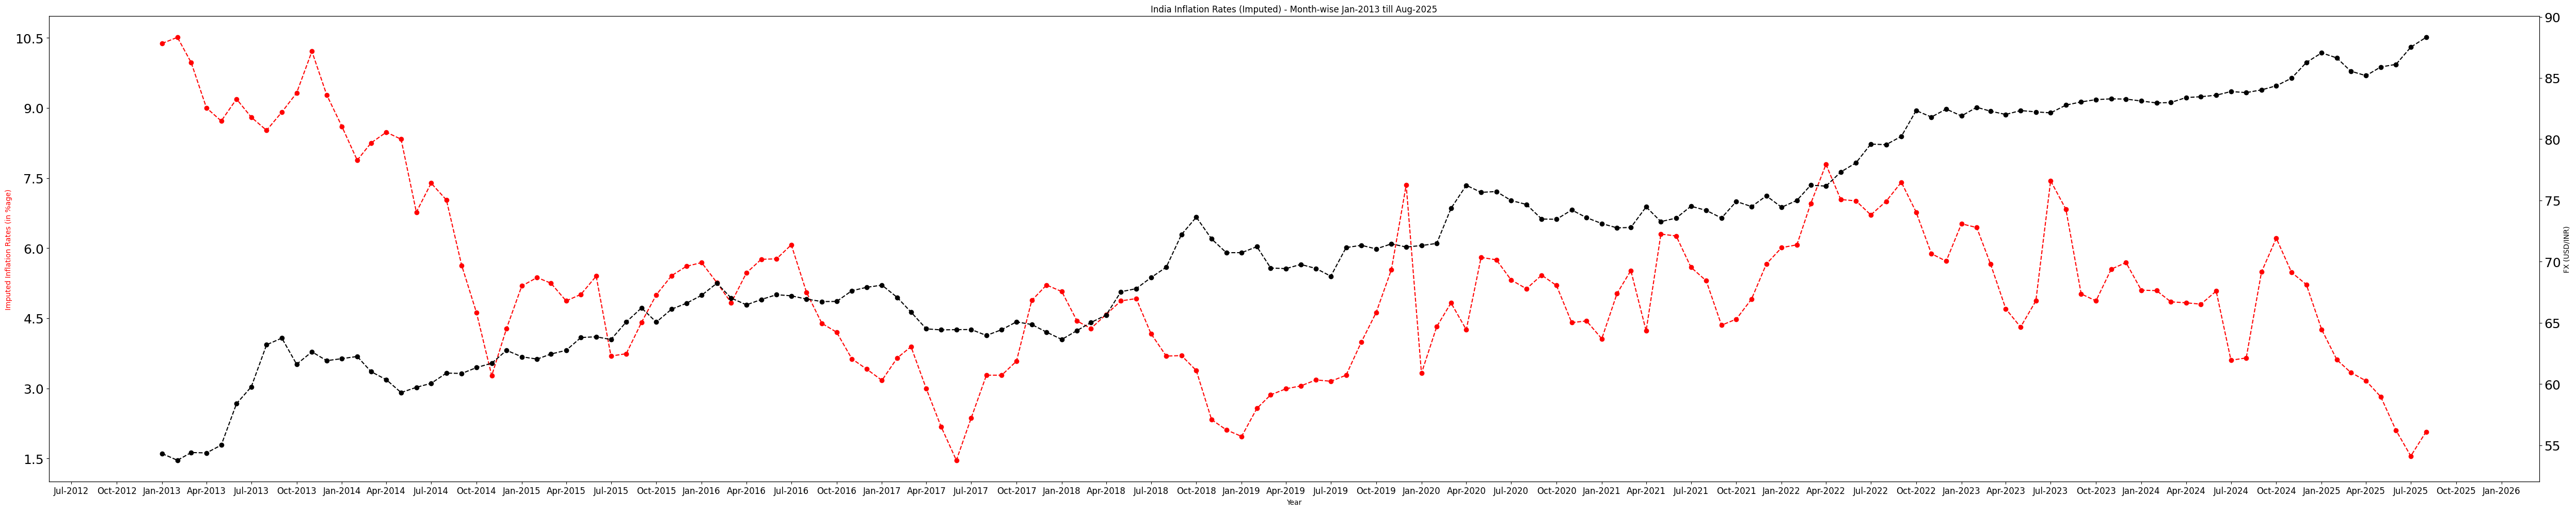

Pearson Correlation Between USD/INR and Inflation
Correlation: -0.3135 and P-value: 0.0001

Pearson Correlation Result (USD/INR and Inflation):
Medium to weak negative linear correlation between fx and inflation.
Stationarity Test (ADF) on FX Dataset - Trend Component:
Test results:
Test statistic: -0.9510507510417838
P-value: 0.7706964061825692
Number of observations: 150
Lags used: 1

ADF Test Conclusion:
Fail to Reject H0: Series has a unit root - non-stationary.
Stationarity Test (KPSS) on FX Dataset - Trend Component:
Test results:
Test statistic: 1.734475155761087
P-value: 0.01
Lags used: 8

KPSS Test Conclusion:
Reject H0: Series is non-stationary.


In [125]:
# Load data
monthly_avg_fx_usd_inr_2013_2025 = os.getenv('monthly_avg_fx_usd_inr_2013_2025')
df_fx = pd.read_csv(monthly_avg_fx_usd_inr_2013_2025)
df_fx['Period'] = pd.to_datetime(df_fx['Period'])
df_fx.set_index('Period', inplace=True)

# Plotting Brent Crude and Inflation Data
X_series = df_inflation_imputed.index
Y_series_inflation = df_inflation_imputed['CPI_Inflation_YoY_Percent_Imputed']
Y_series_fx = df_fx['USD_TO_INR']
fig, ax_inf = plt.subplots(figsize=(50, 10), dpi=100)
ax_inf.plot(X_series, Y_series_inflation, '--', color='red', marker='o', label='CPI_Inflation_YoY_Percent_Imputed')
ax_inf.set_title('India Inflation Rates (Imputed) - Month-wise Jan-2013 till Aug-2025')
ax_inf.set_xlabel('Year')
ax_inf.set_ylabel('Imputed Inflation Rates (in %age)', color='red')
ax_inf.set_xticks(X_series)
ax_inf.set_yticks(Y_series_inflation)
ax_inf.xaxis.set_major_locator(mdates.MonthLocator([1, 4, 7, 10]))
ax_inf.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
ax_inf.yaxis.set_major_locator(plt.MaxNLocator(8))
ax_inf.tick_params(axis='x', labelsize=12)
ax_inf.tick_params(axis='y', labelsize=18)
ax_fx = ax_inf.twinx()
ax_fx.plot(X_series, Y_series_fx, '--', color='black', marker='o', label='USD to INR Exchange')
ax_fx.set_ylabel('FX (USD/INR)', color='black')
ax_fx.tick_params(axis='y', labelsize=18)
fig.tight_layout()
plt.show()

# Pearson Correlation
print('=========================================================================')
print('Pearson Correlation Between USD/INR and Inflation')
fx_inf_correl, fx_inf_p_value = pearsonr(df_inflation_imputed['CPI_Inflation_YoY_Percent_Imputed'], df_fx['USD_TO_INR'])
print(f'Correlation: {fx_inf_correl:.4f} and P-value: {fx_inf_p_value:.4f}')
print('\nPearson Correlation Result (USD/INR and Inflation):')
if fx_inf_p_value < 0.05:
    if fx_inf_correl >= 0.70:
        print(f'Strong positive linear correlation between fx and inflation.')
    elif fx_inf_correl >= 0.10 and fx_inf_correl < 0.70:
        print(f'Medium to weak positive linear correlation between fx and inflation.')
    elif fx_inf_correl > -0.10 and fx_inf_correl < 0.10:
        print(f'No/ negligible linear correlation between fx and inflation.')
    elif fx_inf_correl > -0.70 and fx_inf_correl <= -0.10:
        print(f'Medium to weak negative linear correlation between fx and inflation.')
    elif fx_inf_correl <= -0.70:
        print(f'Strong negative linear correlation between fx and inflation.')

# Stationarity Test - Augmented Dickey Fuller
print('=========================================================================')
print('Stationarity Test (ADF) on FX Dataset - Trend Component:')
fx_adf_test_result = adfuller(df_fx['USD_TO_INR'])
fx_adf_test_stat = fx_adf_test_result[0]
fx_adf_test_p_value = fx_adf_test_result[1]
fx_adf_test_lags_used = fx_adf_test_result[2]
fx_adf_test_obs = fx_adf_test_result[3]
print(f'Test results:')
print(f'Test statistic: {fx_adf_test_stat}')
print(f'P-value: {fx_adf_test_p_value}')
print(f'Number of observations: {fx_adf_test_obs}')
print(f'Lags used: {fx_adf_test_lags_used}')

print('\nADF Test Conclusion:')
if fx_adf_test_p_value > 0.05:
    fx_adf_test_output = 'Not Stationary'
    print('Fail to Reject H0: Series has a unit root - non-stationary.')
else:
    fx_adf_test_output = 'Stationary'
    print('Reject H0: Series is stationary.')

# Stationarity Test - KPSS
print('=========================================================================')
print('Stationarity Test (KPSS) on FX Dataset - Trend Component:')
fx_kpss_test_result = kpss(df_fx['USD_TO_INR'])
fx_kpss_test_stat = fx_kpss_test_result[0]
fx_kpss_test_p_value = fx_kpss_test_result[1]
fx_kpss_test_lags_used = fx_kpss_test_result[2]
fx_kpss_test_obs = fx_kpss_test_result[3]
print(f'Test results:')
print(f'Test statistic: {fx_kpss_test_stat}')
print(f'P-value: {fx_kpss_test_p_value}')
print(f'Lags used: {fx_kpss_test_lags_used}')

print('\nKPSS Test Conclusion:')
if fx_kpss_test_p_value > 0.05:
    fx_kpss_test_output = 'Stationary'
    print('Fail to Reject H0: Series is stationary.')
else:
    fx_kpss_test_output = 'Not Stationary'
    print('Reject H0: Series is non-stationary.')

### **5.4. RBI Repo Rate and Inflation**

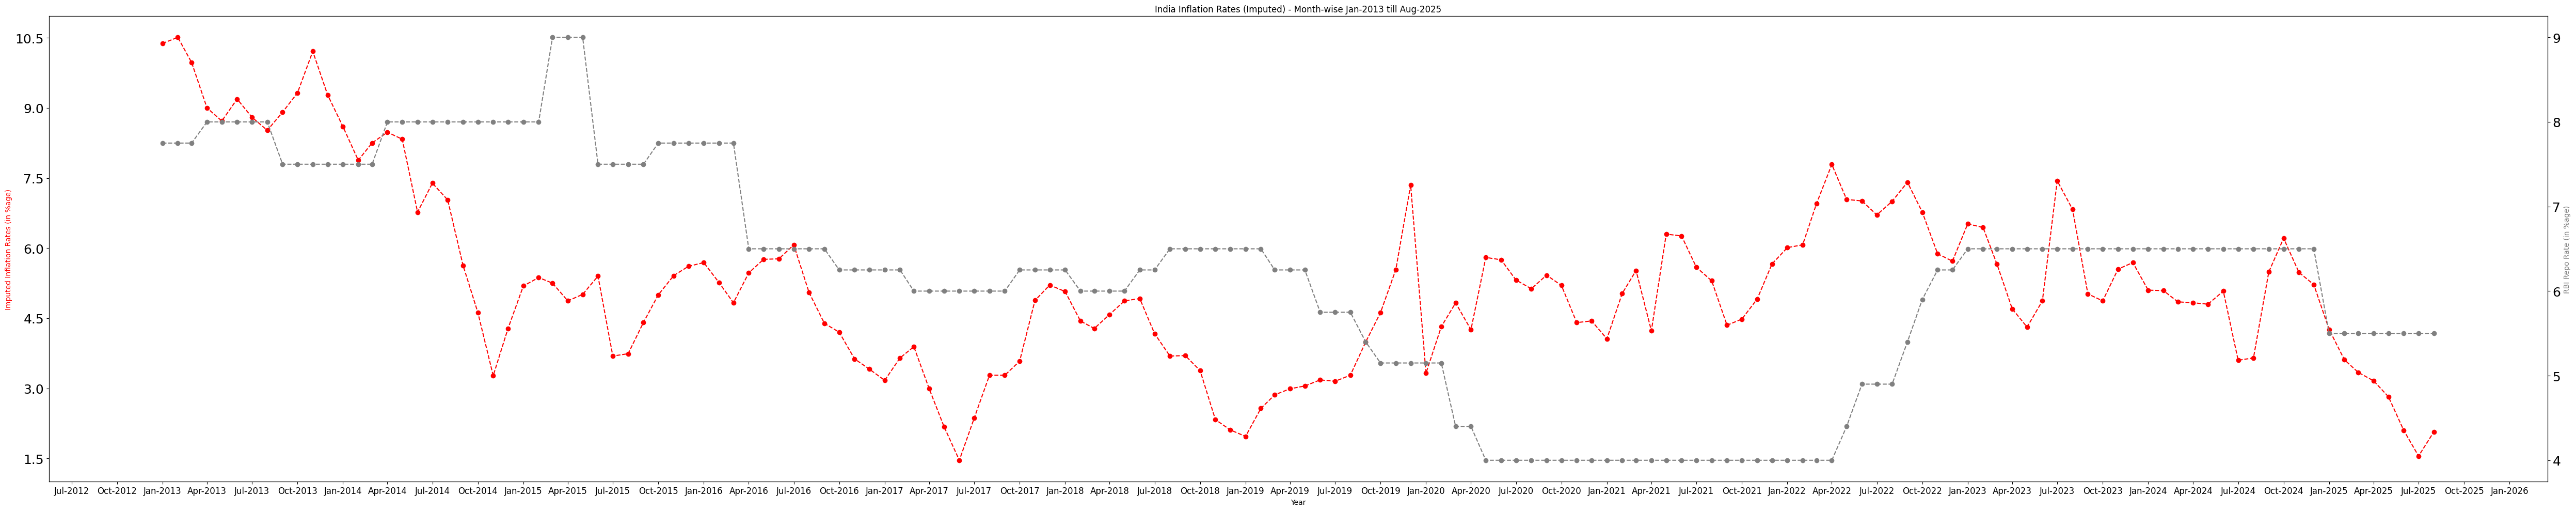

Pearson Correlation Between RBI Repo Rate and Inflation
Correlation: 0.2584 and P-value: 0.0013

Pearson Correlation Result (RBI Repo and Inflation):
Medium to weak positive linear correlation between repo rate and inflation.
Stationarity Test (ADF) on RBI Repo Rate Dataset - Trend Component:
Test results:
Test statistic: -1.3926572681379266
P-value: 0.5857912100731615
Number of observations: 151
Lags used: 0

ADF Test Conclusion:
Fail to Reject H0: Series has a unit root - non-stationary.
Stationarity Test (KPSS) on Repo Rate Dataset - Trend Component:
Test results:
Test statistic: 0.9106666979397792
P-value: 0.01
Lags used: 8

KPSS Test Conclusion:
Reject H0: Series is non-stationary.


In [126]:
# Load data
rbi_repo_2013_2025 = os.getenv('rbi_repo_2013_2025')
df_repo = pd.read_csv(rbi_repo_2013_2025)
df_repo['Period'] = pd.to_datetime(df_repo['Period'])
df_repo.set_index('Period', inplace=True)

# Plotting Brent Crude and Inflation Data
X_series = df_inflation_imputed.index
Y_series_inflation = df_inflation_imputed['CPI_Inflation_YoY_Percent_Imputed']
Y_series_repo = df_repo['Repo_Rate']
fig, ax_inf = plt.subplots(figsize=(50, 10), dpi=100)
ax_inf.plot(X_series, Y_series_inflation, '--', color='red', marker='o', label='CPI_Inflation_YoY_Percent_Imputed')
ax_inf.set_title('India Inflation Rates (Imputed) - Month-wise Jan-2013 till Aug-2025')
ax_inf.set_xlabel('Year')
ax_inf.set_ylabel('Imputed Inflation Rates (in %age)', color='red')
ax_inf.set_xticks(X_series)
ax_inf.set_yticks(Y_series_inflation)
ax_inf.xaxis.set_major_locator(mdates.MonthLocator([1, 4, 7, 10]))
ax_inf.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
ax_inf.yaxis.set_major_locator(plt.MaxNLocator(8))
ax_inf.tick_params(axis='x', labelsize=12)
ax_inf.tick_params(axis='y', labelsize=18)
ax_repo = ax_inf.twinx()
ax_repo.plot(X_series, Y_series_repo, '--', color='grey', marker='o', label='RBI Repo Rate')
ax_repo.set_ylabel('RBI Repo Rate (in %age)', color='grey')
ax_repo.tick_params(axis='y', labelsize=18)
fig.tight_layout()
plt.show()

# Pearson Correlation
print('=========================================================================')
print('Pearson Correlation Between RBI Repo Rate and Inflation')
repo_inf_correl, repo_inf_p_value = pearsonr(df_inflation_imputed['CPI_Inflation_YoY_Percent_Imputed'], df_repo['Repo_Rate'])
print(f'Correlation: {repo_inf_correl:.4f} and P-value: {repo_inf_p_value:.4f}')
print('\nPearson Correlation Result (RBI Repo and Inflation):')
if repo_inf_p_value < 0.05:
    if repo_inf_correl >= 0.70:
        print(f'Strong positive linear correlation between repo rate and inflation.')
    elif repo_inf_correl >= 0.10 and repo_inf_correl < 0.70:
        print(f'Medium to weak positive linear correlation between repo rate and inflation.')
    elif repo_inf_correl > -0.10 and repo_inf_correl < 0.10:
        print(f'No/ negligible linear correlation between repo rate and inflation.')
    elif repo_inf_correl > -0.70 and repo_inf_correl <= -0.10:
        print(f'Medium to weak negative linear correlation between repo rate and inflation.')
    elif repo_inf_correl <= -0.70:
        print(f'Strong negative linear correlation between repo rate and inflation.')

# Stationarity Test - Augmented Dickey Fuller
print('=========================================================================')
print('Stationarity Test (ADF) on RBI Repo Rate Dataset - Trend Component:')
repo_adf_test_result = adfuller(df_repo['Repo_Rate'])
repo_adf_test_stat = repo_adf_test_result[0]
repo_adf_test_p_value = repo_adf_test_result[1]
repo_adf_test_lags_used = repo_adf_test_result[2]
repo_adf_test_obs = repo_adf_test_result[3]
print(f'Test results:')
print(f'Test statistic: {repo_adf_test_stat}')
print(f'P-value: {repo_adf_test_p_value}')
print(f'Number of observations: {repo_adf_test_obs}')
print(f'Lags used: {repo_adf_test_lags_used}')

print('\nADF Test Conclusion:')
if repo_adf_test_p_value > 0.05:
    repo_adf_test_output = 'Not Stationary'
    print('Fail to Reject H0: Series has a unit root - non-stationary.')
else:
    repo_adf_test_output = 'Stationary'
    print('Reject H0: Series is stationary.')

# Stationarity Test - KPSS
print('=========================================================================')
print('Stationarity Test (KPSS) on Repo Rate Dataset - Trend Component:')
repo_kpss_test_result = kpss(df_repo['Repo_Rate'])
repo_kpss_test_stat = repo_kpss_test_result[0]
repo_kpss_test_p_value = repo_kpss_test_result[1]
repo_kpss_test_lags_used = repo_kpss_test_result[2]
repo_kpss_test_obs = repo_kpss_test_result[3]
print(f'Test results:')
print(f'Test statistic: {repo_kpss_test_stat}')
print(f'P-value: {repo_kpss_test_p_value}')
print(f'Lags used: {repo_kpss_test_lags_used}')

print('\nKPSS Test Conclusion:')
if repo_kpss_test_p_value > 0.05:
    repo_kpss_test_output = 'Stationary'
    print('Fail to Reject H0: Series is stationary.')
else:
    repo_kpss_test_output = 'Not Stationary'
    print('Reject H0: Series is non-stationary.')

### **5.5 Collective Interpretation of Empirical Tests on Exogenous Variables**

The empirical tests performed on the four exogenous variables (CFPI, Brent crude, USD/INR exchange rate, and the RBI Repo Rate) show that each variable exhibits meaningful comovement with headline CPI inflation. Pearson correlation coefficients range from strong (CFPI) to medium or weak (Brent, FX, Repo), indicating that these factors contain relevant information for explaining fluctuations in inflation over the sample period.

Stationarity diagnostics using the ADF and KPSS tests reveal that some exogenous variables behave as trend-stationary processes, while others behave as difference-stationary processes. These results help characterize the statistical nature of each regressor but do not dictate preprocessing steps.

In the ARIMAX framework, the differencing operator applies only to the endogenous variable $y_t$. Exogenous regressors $X_t$ enter the model contemporaneously and do not affect the autoregressive error structure. As a result, non-stationary exogenous variables do not require differencing. Including exogenous variables in levels preserves their informational content and does not compromise model validity, provided that the ARIMA component ensures stationarity of $y_t$ after differencing.

In summary, the empirical diagnostics confirm that all four variables are appropriate candidates for inclusion as exogenous regressors: correlations indicate relevance, while stationarity properties inform interpretation without necessitating differencing.

**Summary Results**

| Variable                | Correlation with Inflation | Correlation Strength        | Stationarity Classification                         |
|-------------------------|----------------------------|-----------------------------|-----------------------------------------------------|
| CFPI (Food & Beverages) | 0.7851                     | Strong Positive             | Trend-stationary (ADF: NS, KPSS: S)                 |
| Brent Crude Prices      | 0.6314                     | Medium Positive             | Trend-stationary (ADF: NS, KPSS: S)                 |
| USD/INR Exchange Rate   | −0.3135                    | Medium to Weak Negative     | Difference-stationary (ADF: NS, KPSS: NS)           |
| RBI Repo Rate           | 0.2584                     | Medium to Weak Positive     | Difference-stationary (ADF: NS, KPSS: NS)           |


*Legend*

 - S = stationary (fail to reject KPSS null)
 - NS = non-stationary (reject KPSS or fail ADF)
 - Trend-stationary = ADF: NS and KPSS: S
 - Difference-stationary = ADF: NS and KPSS: NS

## **Section 6: 5-year Forecast**

This section focuses on leveraging the finalized datasets (endogenous variable - inflation + 4 exogenous variables - CFPI, FX, Brent and Repo) to compare performance of ARIMAX and XGBoost across the identified parameters.

### **6.1. ARIMAX (Autoregressive Integrated Moving Average with Exogenous Variables)**

This section focuses on fitting an ARIMAX model to observe changes to RMSE, MAE, Log-Likelihood, AIC and BIC outcomes. Since seasonality tests have already been performed on the imputed data in the above sections, we shall not repeat the same here. ARIMAX extends ARIMA by incorporating exogenous variables — specifically, CFPI, FX, Brent and Repo Rate in our use case. Augmenting the endogenous variable (CPI Inflation Rate) with relevant exogenous variables is a widely recommended practice in time series modelling, as it allows the model to capture external structural drivers of the endogenous variable. Therefore, these variables are integrated into the ARIMAX specification to enhance predictive accuracy and improve overall model performance.

#### **About ARIMAX**

ARIMAX (AutoRegressive Integrated Moving Average with eXogenous regressors) is a classical time–series model that combines:

- Non-seasonal ARIMA structure  
- Exogenous regressors (covariates)  
- A full state–space representation  

ARIMAX models a dependent variable $Y_t$ using its own lagged structure together with the influence of one or more external variables $X_t$. A time–series is suitable for ARIMAX when it exhibits:

- Dependence on its past values (autocorrelation),  
- Trend or stochastic integration,  
- No meaningful seasonal periodicity requiring seasonal differencing,  
- External drivers that influence the evolution of the series.  

The general form of ARIMAX is:

$$
Y_t = \mu_t + \beta^\top X_t + \varepsilon_t
$$

where $\mu_t$ is the ARIMA component capturing internal time–series structure, and $\beta^\top X_t$ captures the effect of exogenous regressors.



##### **ARIMAX Components**

ARIMAX extends ARIMA by adding external regressors. The model is written as:

$$
ARIMAX(p, d, q)
$$

The components are:



##### **1. AR (AutoRegressive – Non-seasonal)**

The non-seasonal AR $p$ portion relates $Y_t$ to its $p$ most recent past values:

$$
\phi(B)(Y_t) = c + \beta^\top X_t + \theta(B)\varepsilon_t
$$

or explicitly,

$$
Y_t = c + \phi_1 Y_{t-1} + \dots + \phi_p Y_{t-p} + \beta^\top X_t + \varepsilon_t
$$



##### **2. I (Integrated – Non-seasonal differencing)**

Non-seasonal differencing removes stochastic trend. The differencing operator is:

$$
\nabla^d Y_t = (1 - B)^d Y_t
$$

Examples:

If $d = 1$:

$$
\nabla Y_t = Y_t - Y_{t-1}
$$

If $d = 2$:

$$
\nabla^2 Y_t = Y_t - 2Y_{t-1} + Y_{t-2}
$$



##### **3. MA (Moving Average – Non-seasonal)**

The MA $q$ component relates $Y_t$ to past forecast errors:

$$
Y_t = c + \beta^\top X_t + \varepsilon_t
      + \theta_1 \varepsilon_{t-1}
      + \dots
      + \theta_q \varepsilon_{t-q}
$$



##### **Unified ARIMAX Representation**

After applying non-seasonal differencing, define:

$$
W_t = \nabla^d Y_t
$$

A simplified ARIMAX representation is:

$$
W_t =
c
+ \phi_1 W_{t-1}
+ \dots
+ \beta^\top X_t
+ \theta_1 \varepsilon_{t-1}
+ \varepsilon_t
$$



##### **Interpretation**

- The AR and MA components capture short-run autocorrelation.  
- Differencing removes stochastic trends.  
- The exogenous term $\beta^\top X_t$ incorporates external structural drivers.  
- ARIMAX is estimated via Maximum Likelihood in state–space form.  

This framework allows ARIMAX to simultaneously model trend, autocorrelation, and the influence of external regressors.

Number of observations in endogenous training dataset: 128
Number of observations in endogenous test dataset: 12
Number of observations in exogenous training dataset: 128
Number of observations in exogenous test dataset: 12
Model training and RMSE/ MAE results:
Imputed Data RMSE - SARIMAX: 0.3904082503425738
Imputed Data MAE - SARIMAX: 0.33238965448471885
SARIMAX performance on out-of-sample parameters:


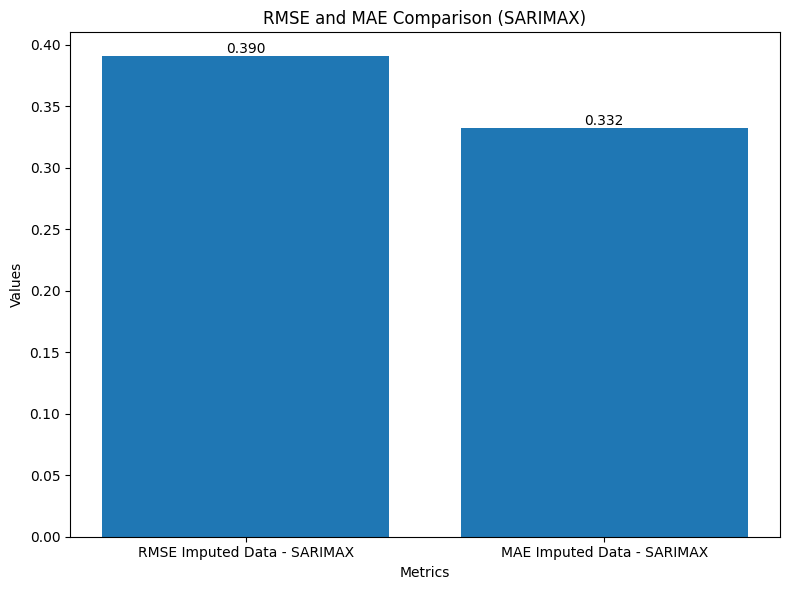

Summary Statistics:
                                       SARIMAX Results                                       
Dep. Variable:     CPI_Inflation_YoY_Percent_Imputed   No. Observations:                  128
Model:                              SARIMAX(1, 0, 0)   Log Likelihood                 -97.099
Date:                               Sat, 06 Dec 2025   AIC                            208.198
Time:                                       08:15:08   BIC                            228.107
Sample:                                   01-01-2014   HQIC                           216.287
                                        - 08-01-2024                                         
Covariance Type:                              robust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
drift             -0.0069      0.003     -2.372      0.018    

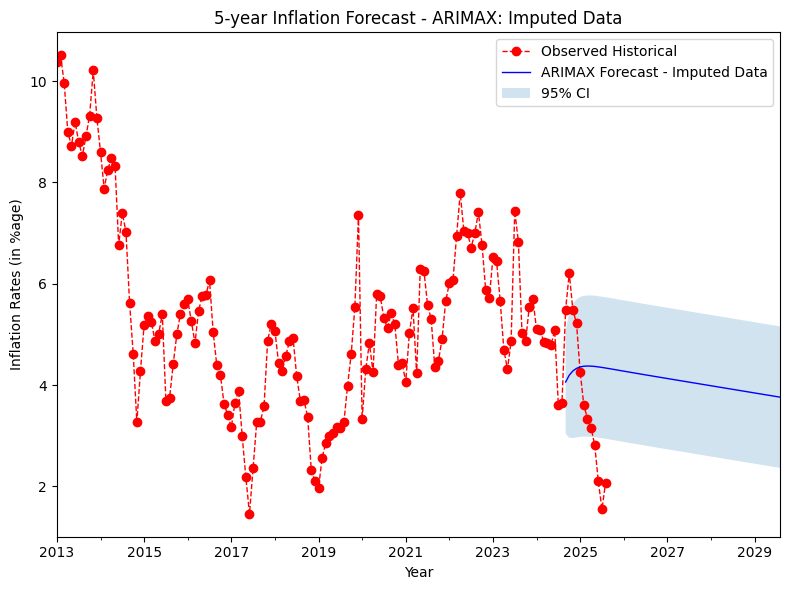

In [127]:
# Generating dataset of endogenous and exogenous variables
print(f'Number of observations in endogenous training dataset: {len(train_endogenous_data['CPI_Inflation_YoY_Percent_Imputed'])}')
print(f'Number of observations in endogenous test dataset: {len(test_endogenous_data['CPI_Inflation_YoY_Percent_Imputed'])}')
df_brent_crude = df_brent_crude[
    df_brent_crude.index >= '2014-01-01'
]
df_fx = df_fx[
    df_fx.index >= '2014-01-01'
]
df_repo = df_repo[
    df_repo.index >= '2014-01-01'
]
df_cfpi.columns = ['CFPI_Values']
df_brent_crude.columns = ['USD_PER_BARREL']
df_fx.columns = ['USD_TO_INR']
df_repo.columns = ['Repo_Rate']
df_exogenous = pd.concat(
    [df_cfpi, df_brent_crude, df_fx, df_repo],
    axis=1,
    join='inner'
)
train_exogenous_data = df_exogenous[
    df_exogenous.index <= '2024-08-01'
]
test_exogenous_data = df_exogenous[
    df_exogenous.index > '2024-08-01'
]
print(f'Number of observations in exogenous training dataset: {len(train_exogenous_data.index)}')
print(f'Number of observations in exogenous test dataset: {len(test_exogenous_data.index)}')

# Training SARIMAX model on Imputed Data and Calculating Errors
print('Model training and RMSE/ MAE results:')
model_sarimax_imputed = SARIMAX(
    endog=train_endogenous_data['CPI_Inflation_YoY_Percent_Imputed'], 
    order=(1, inflation_differencing, 0),
    seasonal_order=(0, inflation_differencing, 0, 0),
    trend= inflation_trend,
    exog=train_exogenous_data[['CFPI_Values', 'USD_PER_BARREL', 'USD_TO_INR', 'Repo_Rate']],
    enforce_invertibility=False,
    enforce_stationarity=False
).fit(cov_type='robust')
model_sarimax_imputed_pred = model_sarimax_imputed.get_forecast(
    steps=len(test_endogenous_data['CPI_Inflation_YoY_Percent_Imputed']),
    exog=test_exogenous_data[['CFPI_Values', 'USD_PER_BARREL', 'USD_TO_INR', 'Repo_Rate']]
).predicted_mean
model_sarimax_imputed_rmse = root_mean_squared_error(test_endogenous_data['CPI_Inflation_YoY_Percent_Imputed'], model_sarimax_imputed_pred) 
model_sarimax_imputed_mae = mean_absolute_error(test_endogenous_data['CPI_Inflation_YoY_Percent_Imputed'], model_sarimax_imputed_pred) 
print(f'Imputed Data RMSE - SARIMAX: {model_sarimax_imputed_rmse}')
print(f'Imputed Data MAE - SARIMAX: {model_sarimax_imputed_mae}')
print('SARIMAX performance on out-of-sample parameters:')
Y_comp_values_SARIMAX = [model_sarimax_imputed_rmse, model_sarimax_imputed_mae]
X_comp_values_SARIMAX = ['RMSE Imputed Data - SARIMAX', 'MAE Imputed Data - SARIMAX']
plt.subplots(figsize=(8, 6), dpi=100)
bars = plt.bar(X_comp_values_SARIMAX, Y_comp_values_SARIMAX)
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f'{height:.3f}',
        ha='center', 
        va='bottom',
        fontsize=10
    )
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('RMSE and MAE Comparison (SARIMAX)', fontsize=12)
plt.tight_layout()
plt.show()
print(f'Summary Statistics:\n{model_sarimax_imputed.summary()}')

# Generating Forecast Based on Imputed Data.
print('====================================================================')
print('Generating future index')
future_index_exog = pd.date_range(
    start=train_exogenous_data.index[-1] + pd.offsets.MonthBegin(1),
    periods=60,
    freq='MS'
)
print('Generating 5 year forecast of CFPI using ARIMA')
model_cfpi_forecast = pd.DataFrame(
    {
        'CFPI_Forecast_Values': auto_arima(
            train_exogenous_data['CFPI_Values'], 
            seasonal=False).predict(60)
        }, 
    index=future_index_exog
)
print(f'Generating 5 year forecast of Brent using ARIMA')
model_brent_forecast = pd.DataFrame(
    {
        'Brent_Forecast_Values': auto_arima(
        train_exogenous_data['USD_PER_BARREL'],
        seasonal=False
    ).predict(60)
        },
    index=future_index_exog
)
print(f'Generating 5 year forecast of FX using ARIMA')
model_fx_forecast = pd.DataFrame(
    {
        'FX_Forecast_Values': auto_arima(
        train_exogenous_data['USD_TO_INR'],
        seasonal=False
    ).predict(60)
        },
    index=future_index_exog
)
print(f'Generating 5 year forecast of Repo using FFill')
last_repo_value = train_exogenous_data['Repo_Rate'].iloc[-1]
model_repo_forecast = pd.DataFrame(
    {
        'Repo_Forecast_Values': [last_repo_value] * 60
        },
    index=future_index_exog
)
print('====================================================================')
print('Generating consolidated 5-year forecast of exogenous variables:')
df_exogenous_forecast = pd.DataFrame(
    {
        'CFPI_Forecast_Values': model_cfpi_forecast['CFPI_Forecast_Values'],
        'Brent_Forecast_Values': model_brent_forecast['Brent_Forecast_Values'],
        'FX_Forecast_Values': model_fx_forecast['FX_Forecast_Values'],
        'Repo_Forecast_Values': model_repo_forecast['Repo_Forecast_Values']
        },
    index=future_index_exog
)
print('====================================================================')
print('Generating 5-year forecast based on imputed dataset:')
model_sarimax_imputed_forecast = model_sarimax_imputed.get_forecast(
    steps=60,
    exog=df_exogenous_forecast[['CFPI_Forecast_Values', 'Brent_Forecast_Values', 'FX_Forecast_Values', 'Repo_Forecast_Values']]
)
model_sarimax_imputed_forecast_summary = model_sarimax_imputed_forecast.summary_frame(alpha=0.05)
df_prediction_data_sarimax_imp = model_sarimax_imputed_forecast_summary[['mean', 'mean_se', 'mean_ci_lower', 'mean_ci_upper']]
df_prediction_data_sarimax_imp.index.name = 'Period'
df_prediction_data_sarimax_imp.to_csv(arimax_forecast_imputed_dataset)
model_sarimax_imputed_forecast_summary.index = pd.to_datetime(model_sarimax_imputed_forecast_summary.index, errors='coerce')
fig_forecast_imp, ax_forecast_imp = plt.subplots(figsize=(8, 6), dpi=100)
df_inflation_imputed['CPI_Inflation_YoY_Percent_Imputed'].plot(ax=ax_forecast_imp, label='Observed Historical', 
                lw=1, color='red', 
                linestyle='--', marker='o')
model_sarimax_imputed_forecast_summary['mean'].plot(ax=ax_forecast_imp, 
                             label='ARIMAX Forecast - Imputed Data', 
                             lw=1, 
                             color='blue')
ax_forecast_imp.fill_between(model_sarimax_imputed_forecast_summary.index, 
                             model_sarimax_imputed_forecast_summary['mean_ci_lower'], 
                             model_sarimax_imputed_forecast_summary['mean_ci_upper'], 
                             alpha=0.2, 
                             label='95% CI')
ax_forecast_imp.set_xlabel('Year')
ax_forecast_imp.set_ylabel('Inflation Rates (in %age)')
ax_forecast_imp.set_title('5-year Inflation Forecast - ARIMAX: Imputed Data')
ax_forecast_imp.legend()
plt.tight_layout()
plt.show()

### **6.2. XGBoost (Extreme Gradient Boosting) - CUDA Enabled and with Feature Engineering**

This section fits an XGBoost model (using imputed values for 2020–2021) to compare RMSE, MAE, and long-run macro-economic forecast behaviour against ARIMAX. XGBoost is a supervised, non-parametric, tree-ensemble model capable of capturing non-linear relationships, structural breaks, and high-order interactions without assuming linearity, stationarity, or Gaussian error structure. Since XGBoost does not optimize a likelihood-based objective, classical statistical metrics such as Log-Likelihood, AIC, and BIC are not applicable. Instead, the focus is on out-of-sample forecasting accuracy, model stability, and long-run forecast plausibility.

To improve computational efficiency, XGBoost is trained within a CUDA-enabled WSL environment, enabling GPU acceleration relative to CPU-only training.



#### **About XGBoost**

XGBoost (Extreme Gradient Boosting) is an optimized implementation of gradient-boosted decision trees. It builds a sequence of regression trees where each new tree is trained to correct the residual errors of the preceding ensemble.

A model qualifies as a machine-learning ensemble model (such as XGBoost) when:

- it does not rely on explicit time-series structure (e.g., AR/MA terms or differencing), and temporal dependence is learned entirely from lagged features  
- it can represent non-linearities, threshold effects, and interaction effects that cannot be expressed through linear parametric forms  
- it learns by iteratively minimizing a loss function using gradient boosting rather than fitting a parametric stochastic model  



#### **Key Points of Note on XGBoost**

- XGBoost grows trees using a depth-first, leaf-wise strategy, expanding the leaf with the highest Gain. This produces more flexible trees compared to breadth-first CART approaches.  
- Depth-first expansion captures complex local structure earlier in the boosting process.  
- Boosting does not require sampling; for time-series, data must remain strictly chronological to avoid leakage.  



#### **XGBoost Prediction Structure**

XGBoost predictions follow:

$$
\hat{Y}_t = \sum_{k=1}^{K} f_k(X_t), \qquad f_k \in \mathcal{F}
$$

where:

- $X_t$ is the feature vector at time $t$ (e.g., lags: $Y_{t-1}, Y_{t-2}, \ldots$)  
- $f_k$ is the $k^{th}$ regression tree  
- $K$ is the number of boosted trees  
- $\mathcal{F}$ is the space of all possible trees  

The regularized training objective is:

$$
\mathcal{L}
=
\sum_{t=1}^{T}
\ell(Y_t, \hat{Y}_t)
+
\sum_{k=1}^{K}
\Omega(f_k)
$$



#### **Gradient Boosting Mechanics**

Classical gradient boosting fits each new tree to the negative gradient of the loss function:

$$
g_t
=
\frac{\partial \ell(Y_t,\; \hat{Y}_t^{(k-1)})}
{\partial \hat{Y}_t^{(k-1)}}
$$

Predictions are updated as:

$$
\hat{Y}_t^{(k)}
=
\hat{Y}_t^{(k-1)}
+
\eta\, f_k(X_t)
$$

where $\eta$ is the learning rate.  



#### **Second-Order Optimization (XGBoost’s Core Innovation)**

XGBoost uses a second-order Taylor approximation:

$$
\ell(Y_t,\; \hat{Y}_t^{(k-1)} + f_k(X_t))
\approx
\ell(Y_t,\; \hat{Y}_t^{(k-1)})
+
g_t f_k(X_t)
+
\frac{1}{2} h_t f_k(X_t)^2
$$

where $g_t$ and $h_t$ are the first and second derivatives of the loss.

Let:

$$
G_j = \sum_{t \in j} g_t,
\qquad
H_j = \sum_{t \in j} h_t
$$

The optimal leaf weight is:

$$
w_j^{*}
=
-
\frac{G_j}{H_j + \lambda}
$$



#### **Regularization (Complexity Control)**

XGBoost applies explicit regularization:

$$
\Omega(f_k)
=
\gamma T_k
+
\frac{1}{2}\lambda \sum_{j=1}^{T_k} w_j^2
$$

where $T_k$ is the number of leaves and $w_j$ the weight of leaf $j$.



#### **Gain-Based Split Selection**

A split is chosen when it produces positive Gain:

$$
\text{Gain}
=
\frac{1}{2}
\left[
\frac{G_L^2}{H_L + \lambda}
+
\frac{G_R^2}{H_R + \lambda}
-
\frac{(G_L + G_R)^2}{H_L + H_R + \lambda}
\right]
-
\gamma
$$



#### **Feature Engineering for Time-Series**

XGBoost has no built-in awareness of time ordering.  
Temporal dependency must be encoded manually:

$$
X_t
=
\left[
Y_{t-1},\; Y_{t-2},\; \dots,\; Y_{t-L},\;
\text{rolling means},\;
\text{rolling volatilities},\;
\text{calendar features}
\right]
$$

Training data must remain strictly chronological to avoid leakage.



#### **Handling Non-Linearity and Structural Breaks**

XGBoost adaptively partitions the feature space to capture:

- non-linear inflation dynamics  
- abrupt regime changes  
- threshold behaviour  
- interactions between exogenous variables  

This yields greater flexibility than linear econometric models.



#### **Bringing It All Together**

The final XGBoost model is:

$$
\hat{Y}_t
=
\sum_{k=1}^{K}
f_k
\left(
Y_{t-1}, Y_{t-2}, \ldots, Y_{t-L}
\right)
$$

Key differences from ARIMAX/SARIMAX:

- no differencing assumptions  
- no AR or MA operators  
- no stationarity requirement  
- fully non-linear functional form  
- long-run forecasts generated recursively  

XGBoost’s learning process can be summarized as:

- gradient → update direction  
- Hessian → update magnitude  
- regularization → complexity control  
- closed-form leaf weights → efficient optimization  

#### **6.2.1 Feature Engineering and Initial Setup**

In [128]:
# Check CUDA enablement
print(f'XGBoost version: {xgb.__version__}')
try:
    x_small = np.random.rand(100, 25).astype(np.float64)
    y_small = np.random.rand(100).astype(np.float64)
    dtrain_small = xgb.DMatrix(x_small, label=y_small)
    xgb.train(
        {
            'objective': 'reg:squarederror',
            'tree_method': 'hist',
            'device': 'cuda'
        },
        dtrain_small,
        num_boost_round=10
    )
    print(f'XGB enabled with CUDA')
except:
    print('XGB not enabled with CUDA')

# Reviewing raw dataset
print('====================================================================')
df_inflation_imputed = df_inflation_imputed.reset_index()
df_exogenous = df_exogenous.reset_index()
df_inflation_imputed.rename(
    columns={'Date': 'Period'},
    inplace=True
)
print(f'Inflation Dataset Columns:\n{df_inflation_imputed.columns}')
print(f'Exogenous Variables Dataset Columns:\n{df_exogenous.columns}')
df_xgb_inflation_dataset = pd.merge(
    left=df_inflation_imputed,
    right=df_exogenous,
    on='Period',
    how='inner'
)
df_xgb_inflation_dataset.drop(columns='CPI_Inflation_YoY_Percent', inplace=True)
print(f'Final dataset columns:\n{df_xgb_inflation_dataset.columns}')
print(f'Datatypes of raw dataset columns:')
print(f'Period column data type: {df_xgb_inflation_dataset['Period'].dtype}')
print(f'Endogenous column data type: {df_xgb_inflation_dataset['CPI_Inflation_YoY_Percent_Imputed'].dtype}')
print(f'Exogenous columns data types:\n{df_xgb_inflation_dataset[['CFPI_Values', 'USD_PER_BARREL', 'USD_TO_INR', 'Repo_Rate']].dtypes}')

# Performing feature engineering
print('====================================================================')
# Generating month, quarter and year features
df_xgb_inflation_dataset['Month'] = df_xgb_inflation_dataset['Period'].dt.month
df_xgb_inflation_dataset['Quarter'] = df_xgb_inflation_dataset['Period'].dt.quarter
df_xgb_inflation_dataset['Year'] = df_xgb_inflation_dataset['Period'].dt.year

# Differencing inflation data
df_xgb_inflation_dataset['endo_inf_differencing'] = df_xgb_inflation_dataset['CPI_Inflation_YoY_Percent_Imputed'] - df_xgb_inflation_dataset['CPI_Inflation_YoY_Percent_Imputed'].shift(1)

# Generating m-o-m percent changes
df_xgb_inflation_dataset['endo_inf_mom_percent'] = df_xgb_inflation_dataset['CPI_Inflation_YoY_Percent_Imputed'].pct_change()
df_xgb_inflation_dataset['exo_cfpi_mom_percent'] = df_xgb_inflation_dataset['CFPI_Values'].pct_change()

# Generating cumulative means
df_xgb_inflation_dataset['endo_inf_cumulative_mean'] = df_xgb_inflation_dataset['CPI_Inflation_YoY_Percent_Imputed'].expanding().mean()
df_xgb_inflation_dataset['exo_cfpi_cumulative_mean'] = df_xgb_inflation_dataset['CFPI_Values'].expanding().mean()

# Generating lags of 1 (t-1), 2 (t-2) and 3 (t-3)
df_xgb_inflation_dataset['endo_inf_lag_1'] = df_xgb_inflation_dataset['CPI_Inflation_YoY_Percent_Imputed'].shift(1)
df_xgb_inflation_dataset['endo_inf_lag_2'] = df_xgb_inflation_dataset['CPI_Inflation_YoY_Percent_Imputed'].shift(2)
df_xgb_inflation_dataset['endo_inf_lag_3'] = df_xgb_inflation_dataset['CPI_Inflation_YoY_Percent_Imputed'].shift(3)
df_xgb_inflation_dataset['exo_cfpi_lag_1'] = df_xgb_inflation_dataset['CFPI_Values'].shift(1)
df_xgb_inflation_dataset['exo_cfpi_lag_2'] = df_xgb_inflation_dataset['CFPI_Values'].shift(2)
df_xgb_inflation_dataset['exo_cfpi_lag_3'] = df_xgb_inflation_dataset['CFPI_Values'].shift(3)

# Generating 3, 6 and 12 month moving averages
df_xgb_inflation_dataset['endo_inf_ma_3'] = df_xgb_inflation_dataset['CPI_Inflation_YoY_Percent_Imputed'].rolling(3).mean()
df_xgb_inflation_dataset['endo_inf_ma_6'] = df_xgb_inflation_dataset['CPI_Inflation_YoY_Percent_Imputed'].rolling(6).mean()
df_xgb_inflation_dataset['endo_inf_ma_12'] = df_xgb_inflation_dataset['CPI_Inflation_YoY_Percent_Imputed'].rolling(12).mean()
df_xgb_inflation_dataset['exo_cfpi_ma_3'] = df_xgb_inflation_dataset['CFPI_Values'].rolling(3).mean()
df_xgb_inflation_dataset['exo_cfpi_ma_6'] = df_xgb_inflation_dataset['CFPI_Values'].rolling(6).mean()
df_xgb_inflation_dataset['exo_cfpi_ma_12'] = df_xgb_inflation_dataset['CFPI_Values'].rolling(12).mean()

# Generating 3, 6 and 12 month rolling volatility
df_xgb_inflation_dataset['endo_inf_std_3'] = df_xgb_inflation_dataset['CPI_Inflation_YoY_Percent_Imputed'].rolling(3).std()
df_xgb_inflation_dataset['endo_inf_std_6'] = df_xgb_inflation_dataset['CPI_Inflation_YoY_Percent_Imputed'].rolling(6).std()
df_xgb_inflation_dataset['endo_inf_std_12'] = df_xgb_inflation_dataset['CPI_Inflation_YoY_Percent_Imputed'].rolling(12).std()
df_xgb_inflation_dataset['exo_cfpi_std_3'] = df_xgb_inflation_dataset['CFPI_Values'].rolling(3).std()
df_xgb_inflation_dataset['exo_cfpi_std_6'] = df_xgb_inflation_dataset['CFPI_Values'].rolling(6).std()
df_xgb_inflation_dataset['exo_cfpi_std_12'] = df_xgb_inflation_dataset['CFPI_Values'].rolling(12).std()

# Downloading feature dataset
print('====================================================================')
df_xgb_inflation_dataset.dropna(axis=0, how='any', inplace=True)
df_xgb_inflation_dataset.to_csv(feature_dataset)
print('Feature engineered dataset downloaded.')

# Generating target and feature arrays
print('====================================================================')
print('Generating target and feature arrays')
excluded_columns = ['Period', 'CPI_Inflation_YoY_Percent_Imputed']
feature_columns = []
for c in df_xgb_inflation_dataset.columns:
    if c not in excluded_columns:
        feature_columns.append(c)

X_series_XGB = df_xgb_inflation_dataset[feature_columns].values.astype(np.float64)
Y_series_XGB = df_xgb_inflation_dataset['CPI_Inflation_YoY_Percent_Imputed'].values.astype(np.float64)
print(f'Shape of feature array: {X_series_XGB.shape}')
print(f'Shape of target variable array: {Y_series_XGB.shape}')

# Generating train and test datasets
print('====================================================================')
print('Generating training and testing datasets.')
total_records = len(df_xgb_inflation_dataset)
training_dataset_size = int(round(len(df_xgb_inflation_dataset) * 0.90, 0))
test_dataset_size = int(round(len(df_xgb_inflation_dataset) - training_dataset_size, 0))
print(f'Training and testing dataset sizes: {training_dataset_size}, {test_dataset_size}')
X_train_XGB, X_test_XGB = X_series_XGB[0:training_dataset_size], X_series_XGB[training_dataset_size:total_records]
Y_train_XGB, Y_test_XGB = Y_series_XGB[0:training_dataset_size], Y_series_XGB[training_dataset_size:total_records]
print(f'Shape of Feature lables train and test data: {X_train_XGB.shape}, {X_test_XGB.shape}')
print(f'Shape of Target label train and test data: {Y_train_XGB.shape}, {Y_test_XGB.shape}')

# Generating XGBoost DMatrix
print('====================================================================')
print('Generating XGBoost DMatrix.')
dtrain = xgb.DMatrix(X_train_XGB, label=Y_train_XGB, feature_names=feature_columns)
dtest = xgb.DMatrix(X_test_XGB, label=Y_test_XGB, feature_names=feature_columns)

# Allocating XGBoost parameter values
print('====================================================================')
print('Allocating XGBoost parameter values.')
params_XGB = {
    'objective': 'reg:squarederror', # Regression
    'eval_metric': 'rmse',
    'tree_method': 'hist', # Histogram algorithm for training
    'device': 'cuda', # Enable GPU
    'max_depth': 5, # Maximum depth of tree
    'eta': 0.01, # Learning rate
    'subsample': 0.8, # Number of rows randomly sampled for training each tree (80% per tree)
    'sampling_method': 'uniform', # Row sampling strategy for each tree - works in the same principle as SRSWOR
    'colsample_bytree': 0.8, # Number of columns randomly sampled for training each tree (80% per tree)
    'lambda': 0.0, # L2 Regularization (Ridge) to avoid overfitting
    'alpha': 0.0 # L1 Regularization (Lasso) to avoid overfitting - currently set to 0 since we are using L2
}
num_boost_round = 10000 # Number of trees
erly_stopping_rounds = 50 # Stop after 50 if no addiitonal improvements noted
verbose = 50 # Print every 50 rounds
evals = [
    (dtrain, 'Train'),
    (dtest, 'Test')
]

XGBoost version: 3.1.2
XGB enabled with CUDA
Inflation Dataset Columns:
Index(['Period', 'CPI_Inflation_YoY_Percent',
       'CPI_Inflation_YoY_Percent_Imputed'],
      dtype='object')
Exogenous Variables Dataset Columns:
Index(['Period', 'CFPI_Values', 'USD_PER_BARREL', 'USD_TO_INR', 'Repo_Rate'], dtype='object')
Final dataset columns:
Index(['Period', 'CPI_Inflation_YoY_Percent_Imputed', 'CFPI_Values',
       'USD_PER_BARREL', 'USD_TO_INR', 'Repo_Rate'],
      dtype='object')
Datatypes of raw dataset columns:
Period column data type: datetime64[ns]
Endogenous column data type: float64
Exogenous columns data types:
CFPI_Values       float64
USD_PER_BARREL    float64
USD_TO_INR        float64
Repo_Rate         float64
dtype: object
Feature engineered dataset downloaded.
Generating target and feature arrays
Shape of feature array: (129, 30)
Shape of target variable array: (129,)
Generating training and testing datasets.
Training and testing dataset sizes: 116, 13
Shape of Feature lables

#### **6.2.2 Model Training and Identification of Best-fit**

In [129]:
# Training XGBoost model with early stopping enabled and identifying best model with Out-of-Sample Performance.
print('====================================================================')
print('Training XGBoost model with early stopping enabled.')
model_XGB = xgb.train(
    params=params_XGB,
    dtrain=dtrain,
    num_boost_round=num_boost_round,
    early_stopping_rounds=erly_stopping_rounds,
    evals=evals,
    verbose_eval=verbose
)
print(f'Best model iteration: {model_XGB.best_iteration}')

Training XGBoost model with early stopping enabled.
[0]	Train-rmse:1.27319	Test-rmse:1.74043
[50]	Train-rmse:0.79786	Test-rmse:1.20614
[100]	Train-rmse:0.50396	Test-rmse:0.88515
[150]	Train-rmse:0.31966	Test-rmse:0.68492
[200]	Train-rmse:0.20413	Test-rmse:0.56022
[250]	Train-rmse:0.13222	Test-rmse:0.48288
[300]	Train-rmse:0.08523	Test-rmse:0.43348
[350]	Train-rmse:0.05595	Test-rmse:0.40224
[400]	Train-rmse:0.03731	Test-rmse:0.38422
[450]	Train-rmse:0.02513	Test-rmse:0.37283
[500]	Train-rmse:0.01708	Test-rmse:0.36510
[550]	Train-rmse:0.01188	Test-rmse:0.36046
[600]	Train-rmse:0.00846	Test-rmse:0.35716
[650]	Train-rmse:0.00620	Test-rmse:0.35507
[700]	Train-rmse:0.00453	Test-rmse:0.35364
[750]	Train-rmse:0.00344	Test-rmse:0.35270
[800]	Train-rmse:0.00265	Test-rmse:0.35208
[850]	Train-rmse:0.00206	Test-rmse:0.35163
[900]	Train-rmse:0.00163	Test-rmse:0.35140
[950]	Train-rmse:0.00131	Test-rmse:0.35120
[1000]	Train-rmse:0.00105	Test-rmse:0.35103
[1050]	Train-rmse:0.00086	Test-rmse:0.35092
[11

#### **6.2.3 Out-of-Sample Performance Comparison**

XGBoost RMSE: 0.3506183023825813
XGBoost MAE: 0.3018043107252856
XGBoost performance on out-of-sample parameters:


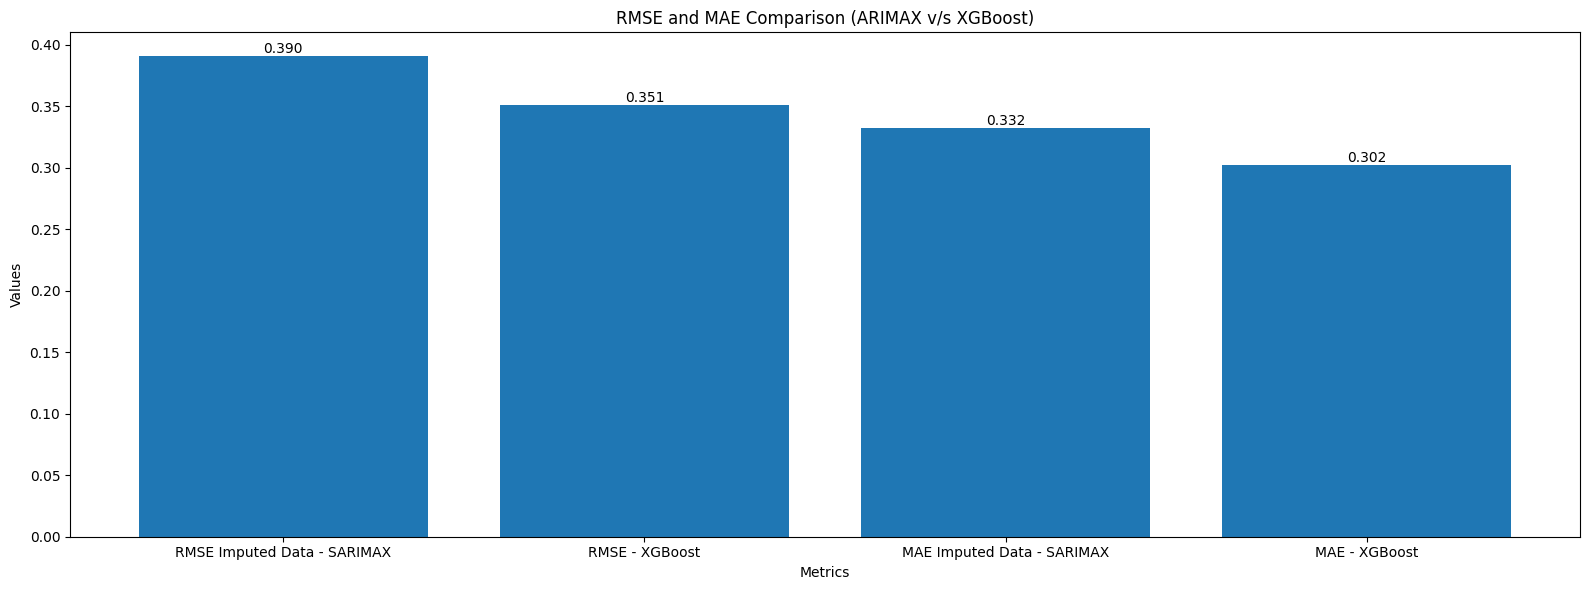

In [130]:
Y_pred_XGB = model_XGB.predict(dtest)
model_XGB_rmse = root_mean_squared_error(Y_test_XGB, Y_pred_XGB)
model_XGB_mae = mean_absolute_error(Y_test_XGB, Y_pred_XGB)
print(f'XGBoost RMSE: {model_XGB_rmse}')
print(f'XGBoost MAE: {model_XGB_mae}')
print('XGBoost performance on out-of-sample parameters:')
Y_comp_values = [model_sarimax_imputed_rmse, model_XGB_rmse, model_sarimax_imputed_mae, model_XGB_mae]
X_comp_values = ['RMSE Imputed Data - SARIMAX', 'RMSE - XGBoost', 'MAE Imputed Data - SARIMAX', 'MAE - XGBoost']
plt.subplots(figsize=(16, 6), dpi=100)
bars = plt.bar(X_comp_values, Y_comp_values)
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f'{height:.3f}',
        ha='center', 
        va='bottom',
        fontsize=10
    )
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('RMSE and MAE Comparison (ARIMAX v/s XGBoost)', fontsize=12)
plt.tight_layout()
plt.show()

#### **6.2.4 Actual v/s Predicted Plot - Test Data**

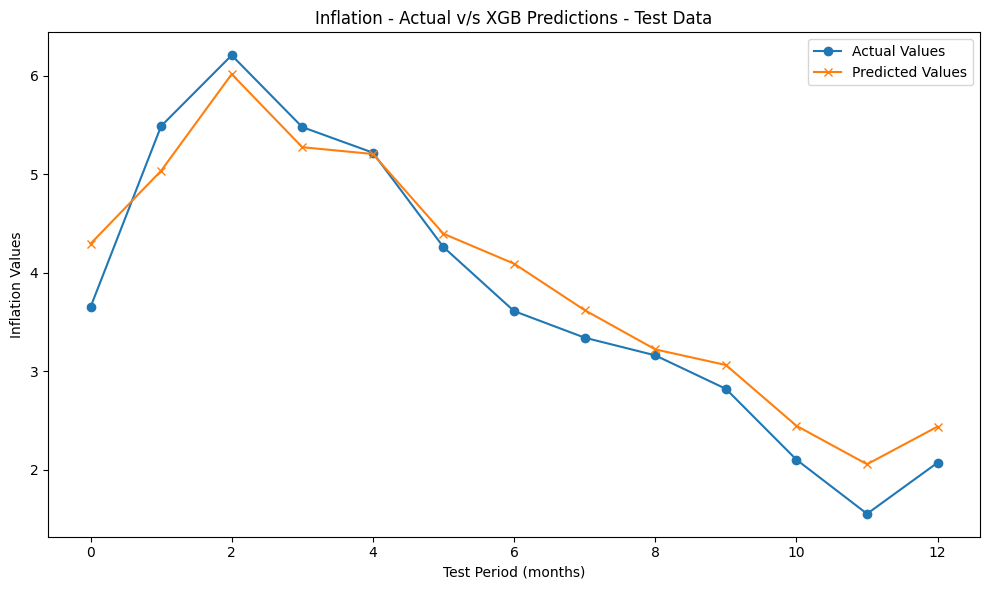

In [131]:
plt.figure(figsize=(10, 6), dpi=100)
plt.plot(Y_test_XGB, label='Actual Values', marker='o')
plt.plot(Y_pred_XGB, label='Predicted Values', marker='x')
plt.title('Inflation - Actual v/s XGB Predictions - Test Data')
plt.xlabel('Test Period (months)')
plt.ylabel('Inflation Values')
plt.legend()
plt.tight_layout()
plt.show()

#### **6.2.5 Generating Forecast Dataset - Using Recursive Forecasting for Endogenous Features**

In [132]:
forecast_period = 60
period_values = dt.strptime('2025-07-01', '%Y-%m-%d')  # last ACTUAL CPI month

# Building exogenous forecast dataframe
df_xgb_inflation_forecast_dataset = pd.DataFrame(columns=df_xgb_inflation_dataset.columns)
df_xgb_inflation_forecast_dataset['Period'] = df_exogenous_forecast.index
df_xgb_inflation_forecast_dataset['CFPI_Values'] = df_exogenous_forecast['CFPI_Forecast_Values'].values
df_xgb_inflation_forecast_dataset['USD_PER_BARREL'] = df_exogenous_forecast['Brent_Forecast_Values'].values
df_xgb_inflation_forecast_dataset['USD_TO_INR'] = df_exogenous_forecast['FX_Forecast_Values'].values
df_xgb_inflation_forecast_dataset['Repo_Rate'] = df_exogenous_forecast['Repo_Forecast_Values'].values

# Generating month, quarter and year features
df_xgb_inflation_forecast_dataset['Month'] = df_xgb_inflation_forecast_dataset['Period'].dt.month
df_xgb_inflation_forecast_dataset['Quarter'] = df_xgb_inflation_forecast_dataset['Period'].dt.quarter
df_xgb_inflation_forecast_dataset['Year'] = df_xgb_inflation_forecast_dataset['Period'].dt.year

# Generating exogenous features
df_xgb_inflation_forecast_dataset['exo_cfpi_cumulative_mean'] = df_xgb_inflation_forecast_dataset['CFPI_Values'].expanding().mean()
df_xgb_inflation_forecast_dataset['exo_cfpi_mom_percent'] = df_xgb_inflation_forecast_dataset['CFPI_Values'].pct_change()
df_xgb_inflation_forecast_dataset['exo_cfpi_lag_1'] = df_xgb_inflation_forecast_dataset['CFPI_Values'].shift(1)
df_xgb_inflation_forecast_dataset['exo_cfpi_lag_2'] = df_xgb_inflation_forecast_dataset['CFPI_Values'].shift(2)
df_xgb_inflation_forecast_dataset['exo_cfpi_lag_3'] = df_xgb_inflation_forecast_dataset['CFPI_Values'].shift(3)
df_xgb_inflation_forecast_dataset['exo_cfpi_ma_3'] = df_xgb_inflation_forecast_dataset['CFPI_Values'].rolling(3).mean()
df_xgb_inflation_forecast_dataset['exo_cfpi_ma_6'] = df_xgb_inflation_forecast_dataset['CFPI_Values'].rolling(6).mean()
df_xgb_inflation_forecast_dataset['exo_cfpi_ma_12'] = df_xgb_inflation_forecast_dataset['CFPI_Values'].rolling(12).mean()
df_xgb_inflation_forecast_dataset['exo_cfpi_std_3'] = df_xgb_inflation_forecast_dataset['CFPI_Values'].rolling(3).std()
df_xgb_inflation_forecast_dataset['exo_cfpi_std_6'] = df_xgb_inflation_forecast_dataset['CFPI_Values'].rolling(6).std()
df_xgb_inflation_forecast_dataset['exo_cfpi_std_12'] = df_xgb_inflation_forecast_dataset['CFPI_Values'].rolling(12).std()

# Removing rows with NULL values in exogenous features
df_xgb_inflation_forecast_dataset.dropna(
    subset=[
        'exo_cfpi_cumulative_mean',
        'exo_cfpi_mom_percent',
        'exo_cfpi_lag_1',
        'exo_cfpi_lag_2',
        'exo_cfpi_lag_3',
        'exo_cfpi_ma_3',
        'exo_cfpi_ma_6',
        'exo_cfpi_ma_12',
        'exo_cfpi_std_3',
        'exo_cfpi_std_6',
        'exo_cfpi_std_12'
    ],
    how='any',
    inplace=True
)

df_xgb_inflation_forecast_dataset.reset_index(drop=True, inplace=True) # Resetting index to safely use iloc / range loops

# Preparing empty endogenous feature columns + target column in forecast DF
endo_cols = [
    'endo_inf_differencing',
    'endo_inf_mom_percent',
    'endo_inf_cumulative_mean',
    'endo_inf_lag_1',
    'endo_inf_lag_2',
    'endo_inf_lag_3',
    'endo_inf_ma_3',
    'endo_inf_ma_6',
    'endo_inf_ma_12',
    'endo_inf_std_3',
    'endo_inf_std_6',
    'endo_inf_std_12'
]
for col in endo_cols:
    df_xgb_inflation_forecast_dataset[col] = np.nan  # endogenous features (to be filled recursively)

# Building initial CPI history = ALL ACTUAL CPI values up to last_training_period
df_xgb_inflation_dataset = df_xgb_inflation_dataset.sort_values('Period')
cpi_history = df_xgb_inflation_dataset.loc[
    df_xgb_inflation_dataset['Period'] <= period_values,
    'CPI_Inflation_YoY_Percent_Imputed'
].copy()
cpi_history = cpi_history.reset_index(drop=True)  # positional indexing

# Feature columns used in XGB model
feature_cols = df_xgb_inflation_dataset.columns.drop([
    'CPI_Inflation_YoY_Percent_Imputed',
    'Period'
])

# Implementing recursive forecasting loop (core logic)
for i in range(len(df_xgb_inflation_forecast_dataset)):

    # Building endogenous features from latest CPI history (latest = Y_t, prev = Y_{t-1}, etc.)
    if len(cpi_history) >= 2:
        y_t   = cpi_history.iloc[-1]
        y_tm1 = cpi_history.iloc[-2]
    else:
        # edge case handling
        y_t, y_tm1 = np.nan, np.nan

    df_xgb_inflation_forecast_dataset.loc[i, 'endo_inf_differencing'] = y_t - y_tm1
    df_xgb_inflation_forecast_dataset.loc[i, 'endo_inf_mom_percent'] = (y_t / y_tm1 - 1) * 100
    df_xgb_inflation_forecast_dataset.loc[i, 'endo_inf_cumulative_mean'] = cpi_history.expanding().mean().iloc[-1]

    # lags
    df_xgb_inflation_forecast_dataset.loc[i, 'endo_inf_lag_1'] = y_t
    df_xgb_inflation_forecast_dataset.loc[i, 'endo_inf_lag_2'] = cpi_history.iloc[-2] if len(cpi_history) >= 2 else np.nan
    df_xgb_inflation_forecast_dataset.loc[i, 'endo_inf_lag_3'] = cpi_history.iloc[-3] if len(cpi_history) >= 3 else np.nan

    # moving averages
    if len(cpi_history) >= 3:
        df_xgb_inflation_forecast_dataset.loc[i, 'endo_inf_ma_3'] = cpi_history.rolling(3).mean().iloc[-1]
        df_xgb_inflation_forecast_dataset.loc[i, 'endo_inf_std_3'] = cpi_history.rolling(3).std().iloc[-1]
    if len(cpi_history) >= 6:
        df_xgb_inflation_forecast_dataset.loc[i, 'endo_inf_ma_6'] = cpi_history.rolling(6).mean().iloc[-1]
        df_xgb_inflation_forecast_dataset.loc[i, 'endo_inf_std_6'] = cpi_history.rolling(6).std().iloc[-1]
    if len(cpi_history) >= 12:
        df_xgb_inflation_forecast_dataset.loc[i, 'endo_inf_ma_12'] = cpi_history.rolling(12).mean().iloc[-1]
        df_xgb_inflation_forecast_dataset.loc[i, 'endo_inf_std_12'] = cpi_history.rolling(12).std().iloc[-1]

    # Building X row for this forecast step
    X_row = df_xgb_inflation_forecast_dataset.loc[[i], feature_cols]  # keep as 1-row DataFrame
    dmatrix_row = xgb.DMatrix(X_row)
    y_pred = model_XGB.predict(dmatrix_row)[0] # Generating CPI prediction for this period
    df_xgb_inflation_forecast_dataset.loc[i, 'CPI_Inflation_YoY_Percent_Imputed'] = y_pred

    # Updating CPI history with new prediction
    # This is where "ACTUAL + PREDICTED up to time t" becomes true:
    # at the start of loop: cpi_history = all actuals
    # after 1st iteration: actuals + 1 prediction
    # after 2nd iteration: actuals + 2 predictions, etc.
    cpi_history = pd.concat([cpi_history, pd.Series([y_pred])], ignore_index=True)

df_xgb_inflation_forecast_dataset.set_index('Period', inplace=True)
df_xgb_inflation_dataset.set_index('Period', inplace=True)
df_xgb_inflation_forecast_dataset.to_csv(xgboost_forecast_imputed_dataset)


#### **6.2.6 Generating Observed Historical v/s Forecast Plot**

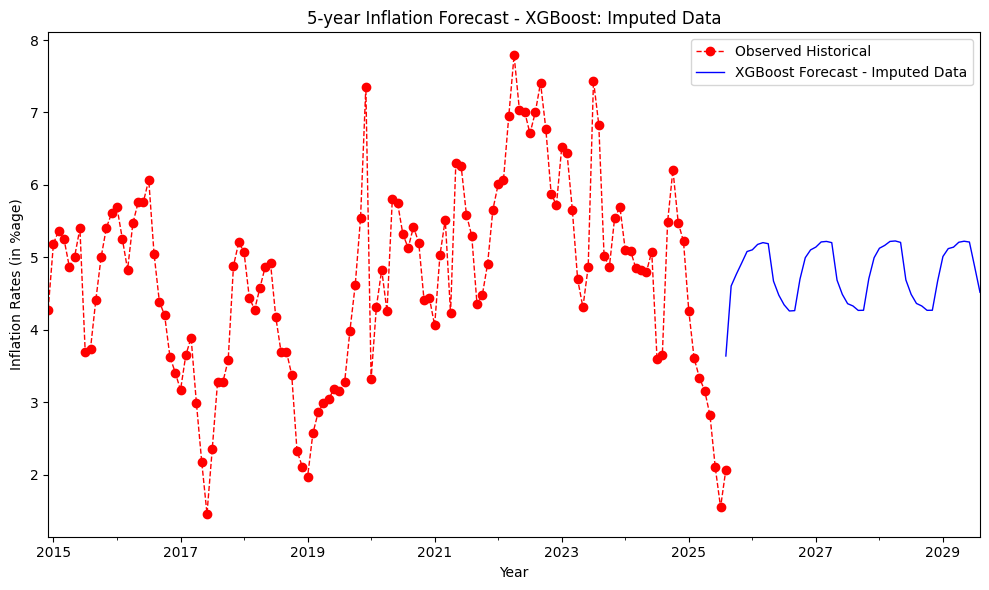

Overall execution time: 16.79 seconds.


In [133]:
fig_forecast_xgb, ax_forecast_xgb = plt.subplots(figsize=(10, 6), dpi=100)
df_xgb_inflation_dataset['CPI_Inflation_YoY_Percent_Imputed'].plot(
    ax=ax_forecast_xgb,
    label='Observed Historical',
    lw=1,
    color='red',
    linestyle='--',
    marker='o'
)
df_xgb_inflation_forecast_dataset['CPI_Inflation_YoY_Percent_Imputed'].plot(
    ax=ax_forecast_xgb,
    label='XGBoost Forecast - Imputed Data',
    lw=1,
    color='blue'
)
ax_forecast_xgb.set_title('5-year Inflation Forecast - XGBoost: Imputed Data')
ax_forecast_xgb.set_xlabel('Year')
ax_forecast_xgb.set_ylabel('Inflation Rates (in %age)')
ax_forecast_xgb.legend()
plt.tight_layout()
plt.show()


# Record program end time and overall execution time
end_time = time.time()
run_time = end_time - start_time
print(f'Overall execution time: {run_time:.2f} seconds.')

## **Section 7: Conclusion**

This section focuses on consolidating the results from this exercise and showcasing the captured strengths and weaknesses of each model.

### **7.1. Out-of-Sample Predictive Strength**

The key performance metrics are:

| **Model** | **RMSE** | **MAE** |
|-----------|----------|----------|
| ARIMAX    | 0.390    | 0.332    |
| XGBoost   | 0.351    | 0.302    |


Interpretation:

- **XGBoost has lower RMSE and lower MAE**, meaning its predictions are closer on average to true observed inflation in the test (out-of-sample) dataset.
- XGBoost captures short-term dynamics better.
- **From a pure predictive accuracy perspective, XGBoost is the stronger model.**

### **7.2. Forecast Behaviour (Qualitative Assessment)**

#### 1. XGBoost Forecast Behaviour
- The forecast exhibits **oscillatory, seasonal-like cycles**.
- The values remain within a **narrow band** around approximately 4.5%–5.2%.
- Shows **mean-reversion** behavior typical of boosted tree models.
- Captures short-run patterns but **does not project macroeconomic drift or structural shifts**.

#### 2. ARIMAX Forecast Behaviour
- Produces a **smooth downward trajectory**, consistent with historical structural effects.
- Includes **95% confidence intervals**, providing uncertainty quantification.
- Forecast behavior is shaped by trend, seasonality, and exogenous variables.
- May reflect early high-inflation periods and imputed COVID-era adjustments.

### **7.3. Statistical Reliability Assessment**

#### 1. XGBoost (Machine Learning Model)
Strengths:
- High predictive accuracy.
- Captures nonlinear interactions among exogenous variables.
- Performs well on complex relationships.

Limitations:
- **No parametric confidence intervals.**
- Recursive multi-step forecasting accumulates error.
- Requires consistent feature engineering.

#### 2. ARIMAX (Econometric Model)
Strengths:
- Provides **statistical uncertainty bounds**.
- Interpretable coefficients tied to economic structure.
- Well-suited for long-term macro forecasting.

Limitations:
- Less flexible with nonlinear dynamics.
- Often produces smoother forecasts with slower reaction to short-term changes.
- Lower predictive accuracy compared to XGBoost.

### **7.4. Summary**

While XGBoost outperforms ARIMAX on out-of-sample accuracy metrics, its lack of statistical uncertainty quantification makes long-horizon macro-economic interpretation more challenging. ARIMAX, on the other hand, produces structurally consistent forecasts that align with economic theory and provide interpretable uncertainty bounds.

XGBoost’s performance should also be viewed relative to dataset size. With only ~140 monthly observations, the dataset is small for a machine-learning model that typically benefits from hundreds or thousands of samples to learn complex nonlinear structures. Despite this limitation, XGBoost still demonstrates superior short-term predictive power.

Ultimately, the choice between ARIMAX and XGBoost depends on the objective of the analysis:

 - If the goal is point forecast accuracy in the short term → XGBoost is preferred.
 - If the goal is macro-economic plausibility, interpretability, and structured long-run forecasting → ARIMAX is preferred.

Thus, model selection is driven not only by performance metrics but also by dataset size, interpretability requirements, structural consistency, and the intended forecasting horizon.

**End of Document**